In [1]:
# importing packages and modules
import numpy as np
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from io_utils import *
from utils import *
from plotting_utils import *
from analysis_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm
sns.set_context("talk")

colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']
colorsStates = ['tab:orange','tab:blue','tab:green','tab:purple', 'tab:brown']
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]
ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')

In [46]:
# Example subject
subject = 'NYU-09'

In [47]:
# setting hyperparameters
sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 0
priorDirP = [100,10]
maxiter = 300
splitFolds = 5
D = 4 # number of features
sessStop = -1 # last session to use in fitting
K = 3 # states
truepi = np.ones((K))/K
pTanh = 5
signedStimulus = True

# loading data
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=None, signedStimulus=signedStimulus, pTanh=pTanh)
biasedBlockTrials, biasedBlockStartInd, biasedBlockSession, firstBlockSession = get_design_biased_blocks(dfAll, subject, sessInd, sessStop)
N = sessInd[-1] # number data points
presentAll = np.ones((N))
presentTrain, presentTest = split_data(N, sessInd, folds=5, blocks=10, random_state=1)
sess = len(sessInd) - 1


In [48]:
lenSessions = np.zeros((sess))
for s in range(sess):
    lenSessions[s] = sessInd[s+1] - sessInd[s]
avg_session_length = int(np.mean(lenSessions))
print("Average session length is ", avg_session_length)

Average session length is  503


In [49]:
# test log-likelihoods for different K's and sigma's
testLl = []
avgTestLl = []

for K in [1,2,3,4,5]:
    data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')
    p = data['allP']
    w = data['allW']
    llTest = data['testLl']
    
    avgTestLl.append(np.mean(llTest,axis=0))
avgTestLl = [x - avgTestLl[0][0] for x in avgTestLl] # normalizing to GLM-HMM sigma=0 K=1
    

# Figure 2B

Text(0.5, 45.33333333333332, '')

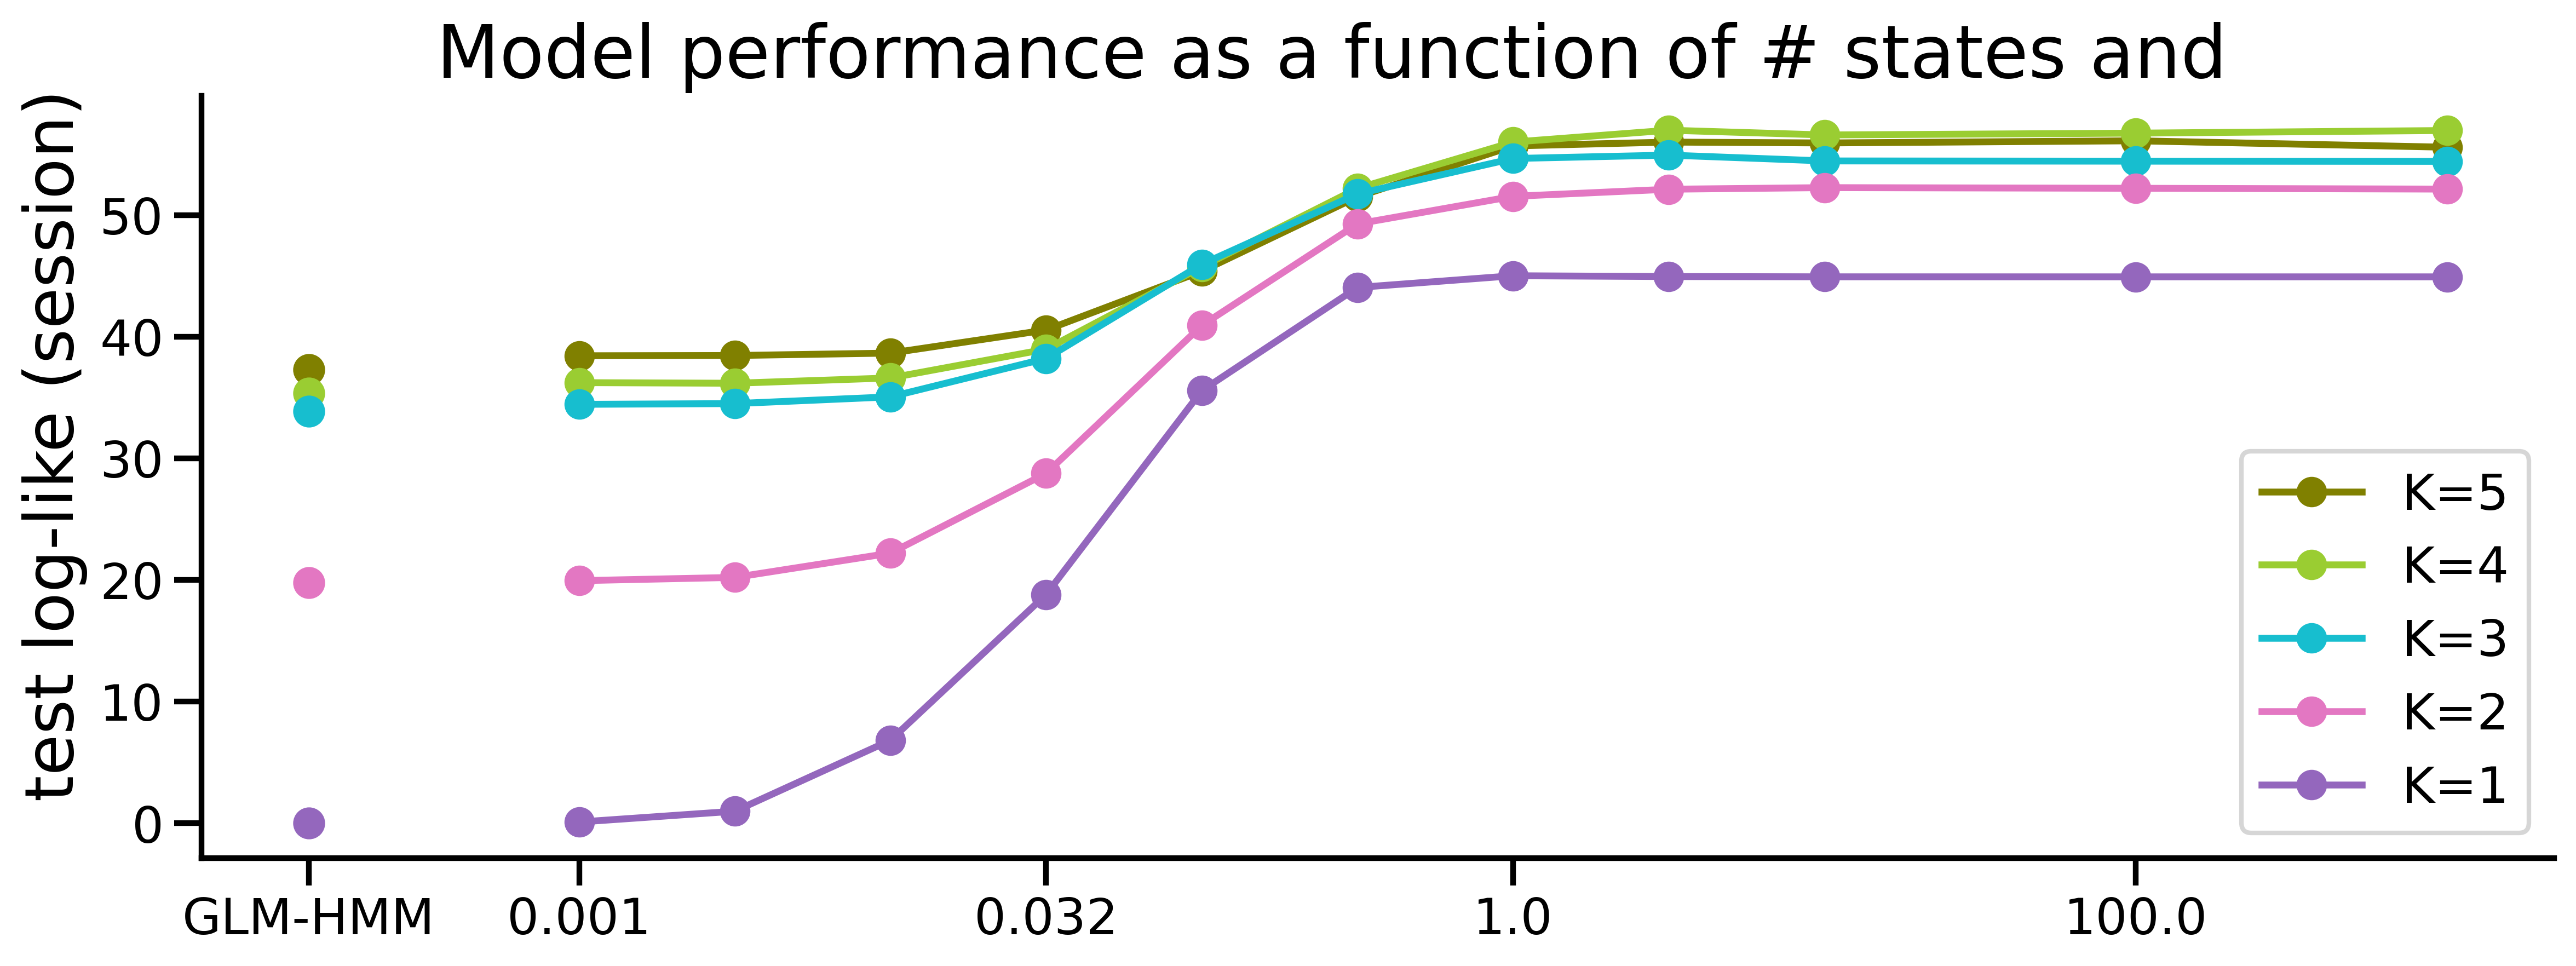

In [50]:
# Plotting delta test log-like averaged across folds as a function of # states and sigma
fig, axes = plt.subplots(1, figsize = (12,4.5), dpi=400)
fig.tight_layout()
for K in range(5,0,-1):
    plot_testLl_CV_sigma(avgTestLl[K-1] * avg_session_length, sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes, size=24)
axes.spines[['right', 'top']].set_visible(False)
axes.set_ylabel("   test log-like (session)", size=22)
axes.set_title('Model performance as a function of # states and    ', size=24)
axes.set_xlabel('')
# plt.savefig(f'../figures/TestLl_vs_K_and_sigma_{subject}.png', bbox_inches='tight', dpi=400)


In [51]:
# load parameters from best model with varying weights and constant transition matrix
K = 3
pi = np.ones((K))
sessionsInterest = [7,15,30]
bestSigmaInd = 7

data = np.load(f'../data_IBL/{subject}/{subject}_partialGLMHMM_CV_{K}-state_pTanh={pTanh}_signedStimulus={signedStimulus}.npz')
allP1 = np.mean(data['allP'], axis=0)
allW1 = np.mean(data['allW'], axis=0) 


In [52]:
# setting other hyperparameters
maxiter = 300
bestSigmaInd = 7 # equivalent to sigma=1, found by cross-validation, sigma is governing the variability of the weights
bestAlphaInd = 2 # equivalent to alpha=2, found by cross-validation, alpha is governing the variability of the transition matrix
priorDirP = [100,10]
fit_init_states = False
bestAlpha = 2 # found by cross-validation, alpha is governing the variability of the transition matrix
K = 3
inits = 21

# Figure 2E

In [34]:
# loading inferred parameters for best fitting model with dynamic weights and transition matrix
_, _, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
param = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}_state_alpha={bestAlpha}_multiple-initsP_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
allP =  param['allP'][0] # 0 mean initialized from best dGLMHMM1 fit
allW =  param['allW'][0] # 0 mean initialized from best dGLMHMM1 fit
 
fig, axes = plt.subplots(1, figsize = (12.5,4.5), dpi=400) # for poster
sess = len(sessInd)-1
for i in range(0,allP.shape[1]):
    axes.axhline(allP1[bestSigmaInd][i,i], linestyle='--', linewidth=2.5, color=colorsStates[i], label=f'state {i+1}', zorder=allP.shape[1]-i, markersize=8)
    axes.plot(range(1,sess+1),allP[sessInd[:-1],i,i],'-', linewidth=3, color=colorsStates[i], label=f'state {i+1}', zorder=allP.shape[1]-i, markersize=8)
    # axes.scatter(range(1,sess+1),allP[sessInd[:-1],i,i],'-', color=colorsStates[i], label=f'state {i+1}', zorder=allP.shape[1]-i)
        
axes.set_ylabel("p(self-transition)", size=22)
axes.set_xlabel('session', size=22)
axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Inferred dynamic transition matrix', size=25)
axes.set_ylim(0.32,1.05)
axes.set_yticks([0.4,0.6,0.8,1],[0.4,0.6,0.8,1])
axes.set_xticks(range(0,80,10), range(0,80,10))
plt.savefig(f'../figures/Self-transition_probabilties-alpha={bestAlpha}_{subject}.png', bbox_inches='tight', dpi=400)
        

TypeError: get_mouse_design() got an unexpected keyword argument 'D'

# Figure 2C

(12, 23, 3, 4, 2)


Text(0.5, 0.98, 'Inferred dynamic weights')

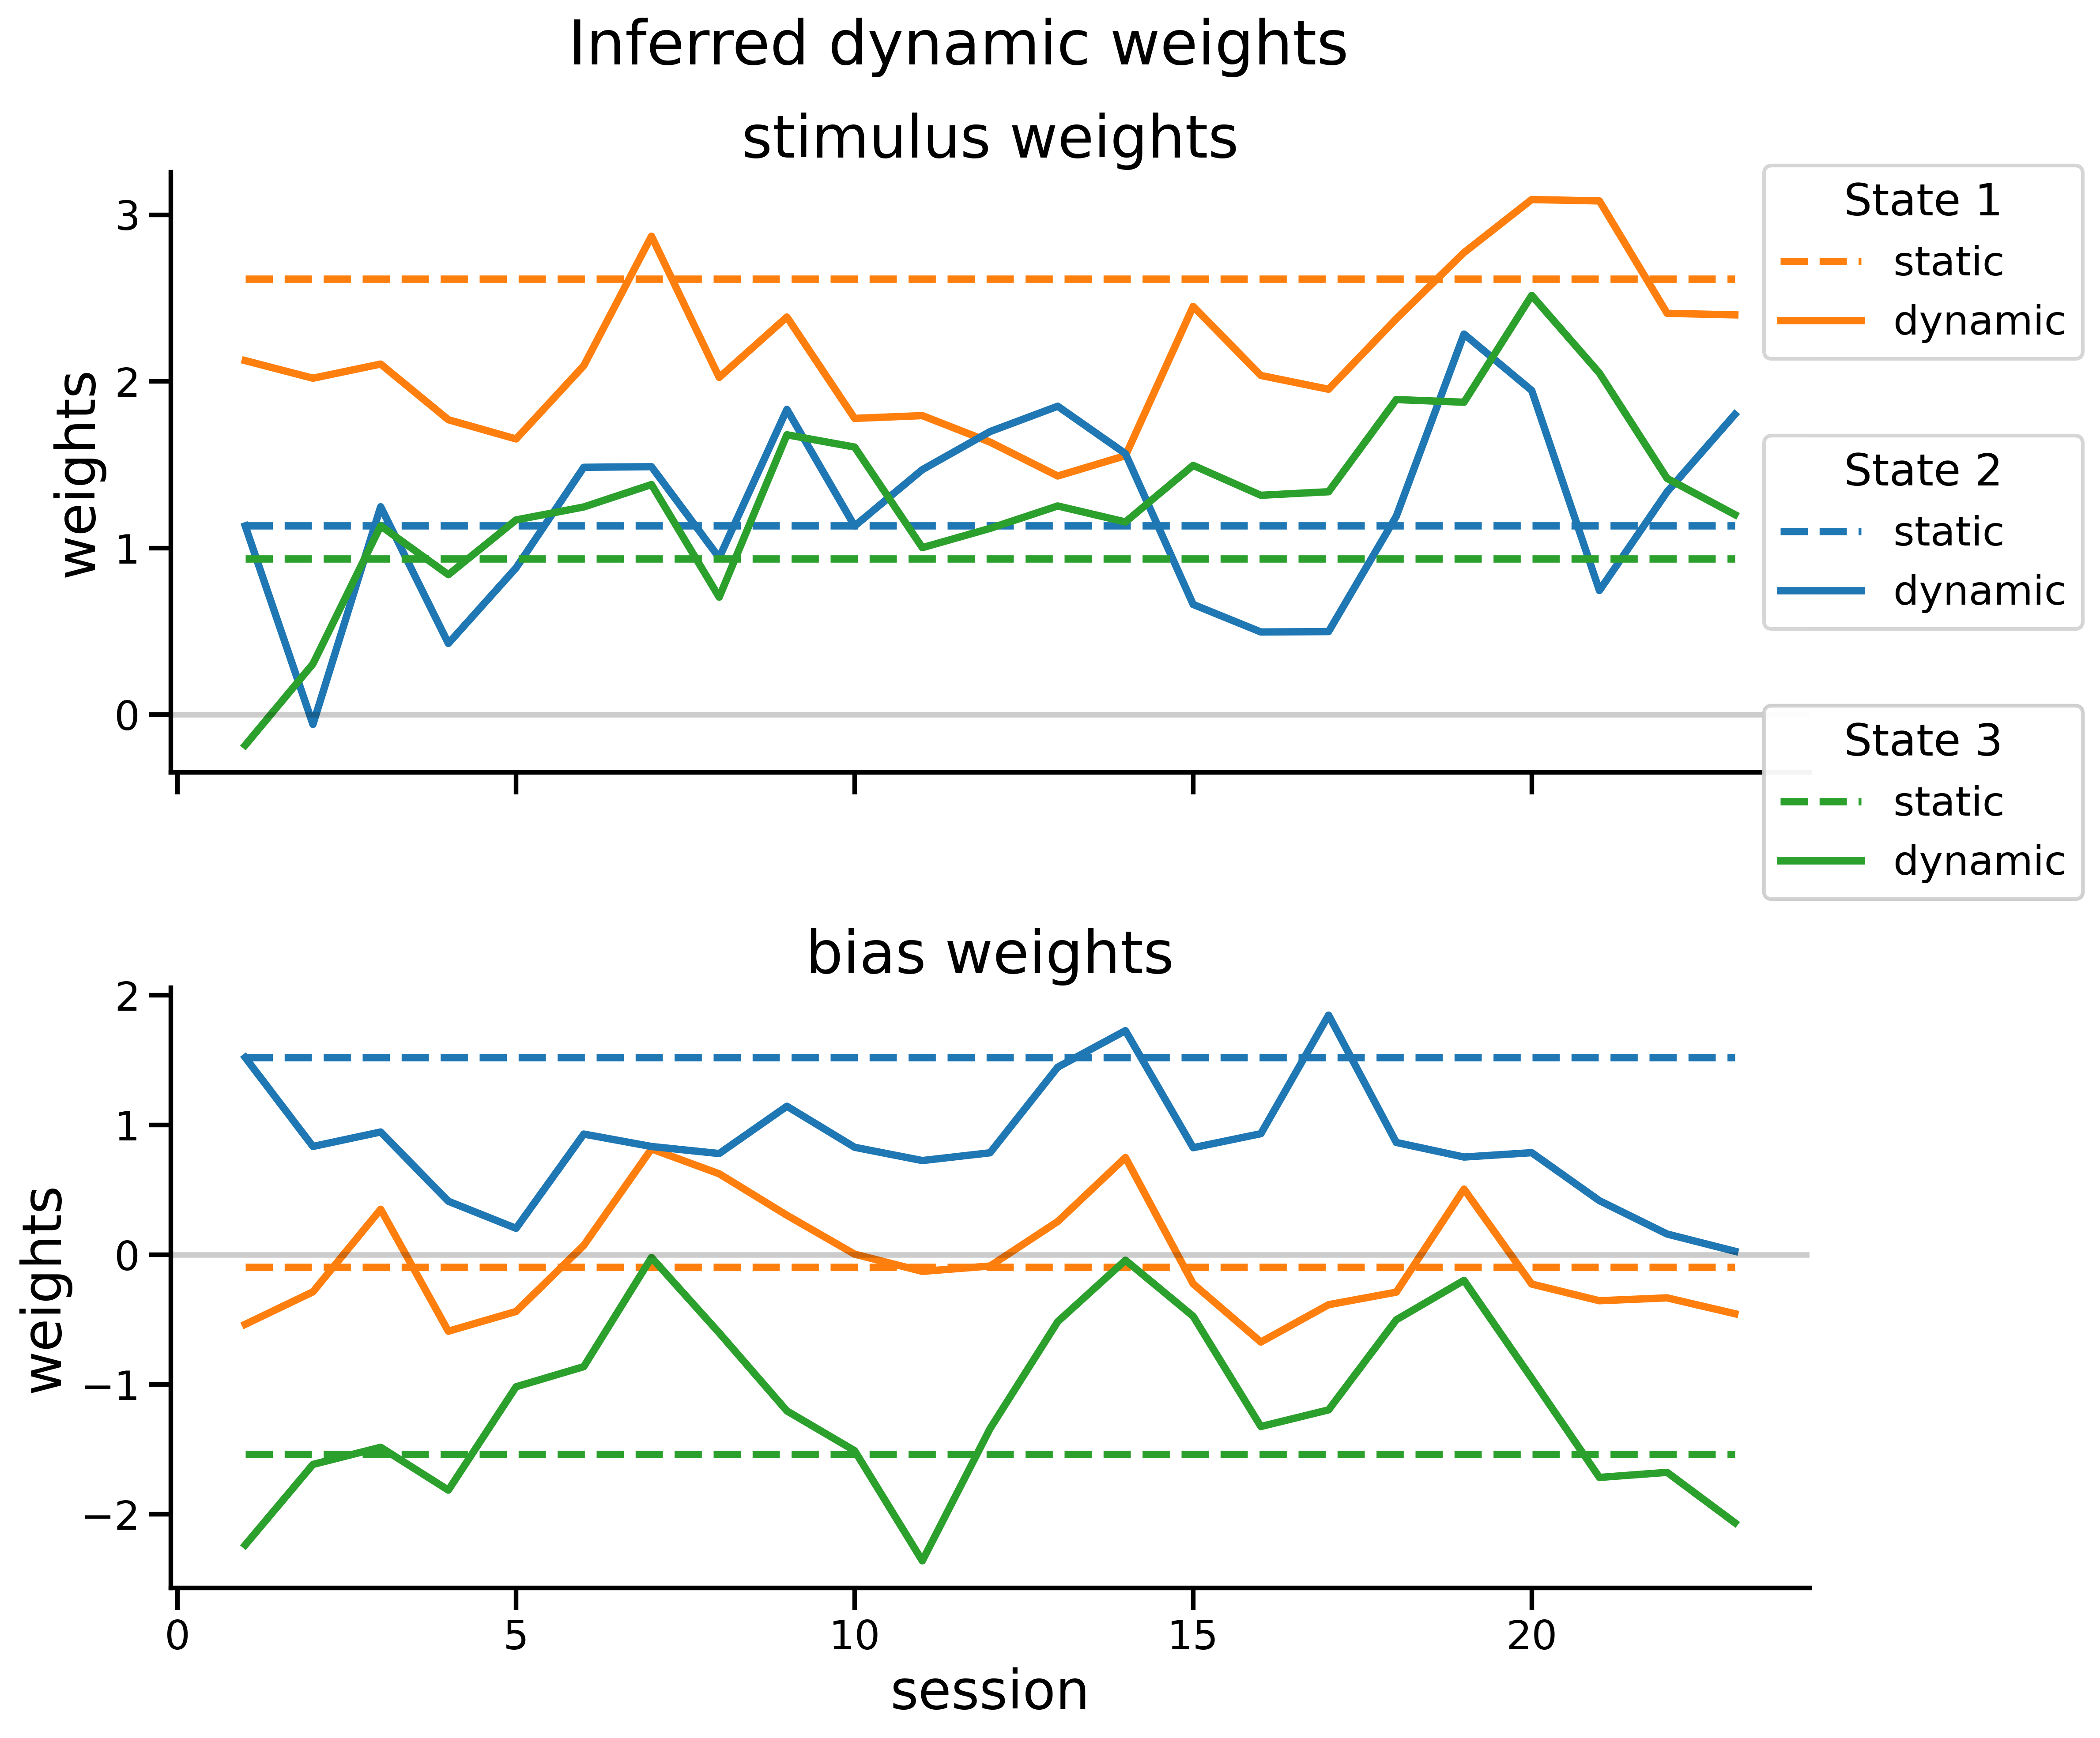

In [53]:
bestSigmaInd = 7
sns.set_context("talk")
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward side'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]

# computing gamma for bestSigmaInd
dGLM_HMM = dynamic_glmhmm.dynamic_GLMHMM(N,K,D,2)
# gamma = dGLM_HMM.get_posterior_latent(allP, truepi, allW, x, y, presentAll, sessInd, sortedStateInd=None)
# phi = dGLM_HMM.observation_probability(x, allW)
   
plotSess = len(sessInd)-1 
print(allW1.shape)
fig, axes = plt.subplots(2, 1,figsize=(12,10.5), sharex=True, dpi=400)
fig.tight_layout(pad=4)
yLim=[[-2.7,2.7],[-0.5,8.2],[-2.7,2.7],[-2.7,2.7]]
for d in range(0, 2):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),allW1[0][:plotSess,k,1-d,1],color=colorsStates[k],linewidth=3, alpha=1, linestyle='--', label='static', zorder=1)
        axes[d].plot(range(1,plotSess+1),allW1[bestSigmaInd][:plotSess,k,1-d,1],color=colorsStates[k],linewidth=3, alpha=1, linestyle='-', label='dynamic', zorder=1)
        # axes[d].plot(range(1,plotSess+1),-allW[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=4, alpha=1, linestyle='-', label='dynamic', zorder=0)
        # for s in sessionsInterest:
        #     axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
    # axes[d].set_ylim(yLim[1-d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights', size=22)
    axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=24)
    axes[d].spines[['right', 'top']].set_visible(False)

# plotting other features 
# for d in range(2, D):
#     axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
#     for k in range(0, K):
#         axes[d].plot(range(1,plotSess+1),-allW1[0][sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=2, alpha=1, linestyle='--', label='   =0', zorder=1)
#         axes[d].plot(range(1,plotSess+1),-allW[sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=4, alpha=1, linestyle='-', label='   =1', zorder=0)
#         # for s in sessionsInterest:
#         #     axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
#     axes[d].set_ylim(yLim[d])
#     # axes[d].set_title(f'{myFeatures[D%2][d]}')
#     axes[d].set_ylabel(f'weights')
#     axes[d].set_title(f'{myFeatures[D%2][d]} weights', size=22)
#     axes[d].spines[['right', 'top']].set_visible(False)
    
lines = axes[0].get_lines()
include = [1,2]
legend1 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, 0.85), title = "State 1")
include = [3,4]
legend2 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, 0.4), title = "State 2")
include = [5,6]
legend3 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, -0.05), title = "State 3")
axes[0].add_artist(legend1)
axes[0].add_artist(legend2)
axes[0].add_artist(legend3)
axes[-1].set_xlabel('session', size=22)
fig.suptitle('Inferred dynamic weights', size=25)
# plt.savefig(f'../figures/weights_sigma=1_{subject}.png', bbox_inches='tight', dpi=400)

# Figure 2F

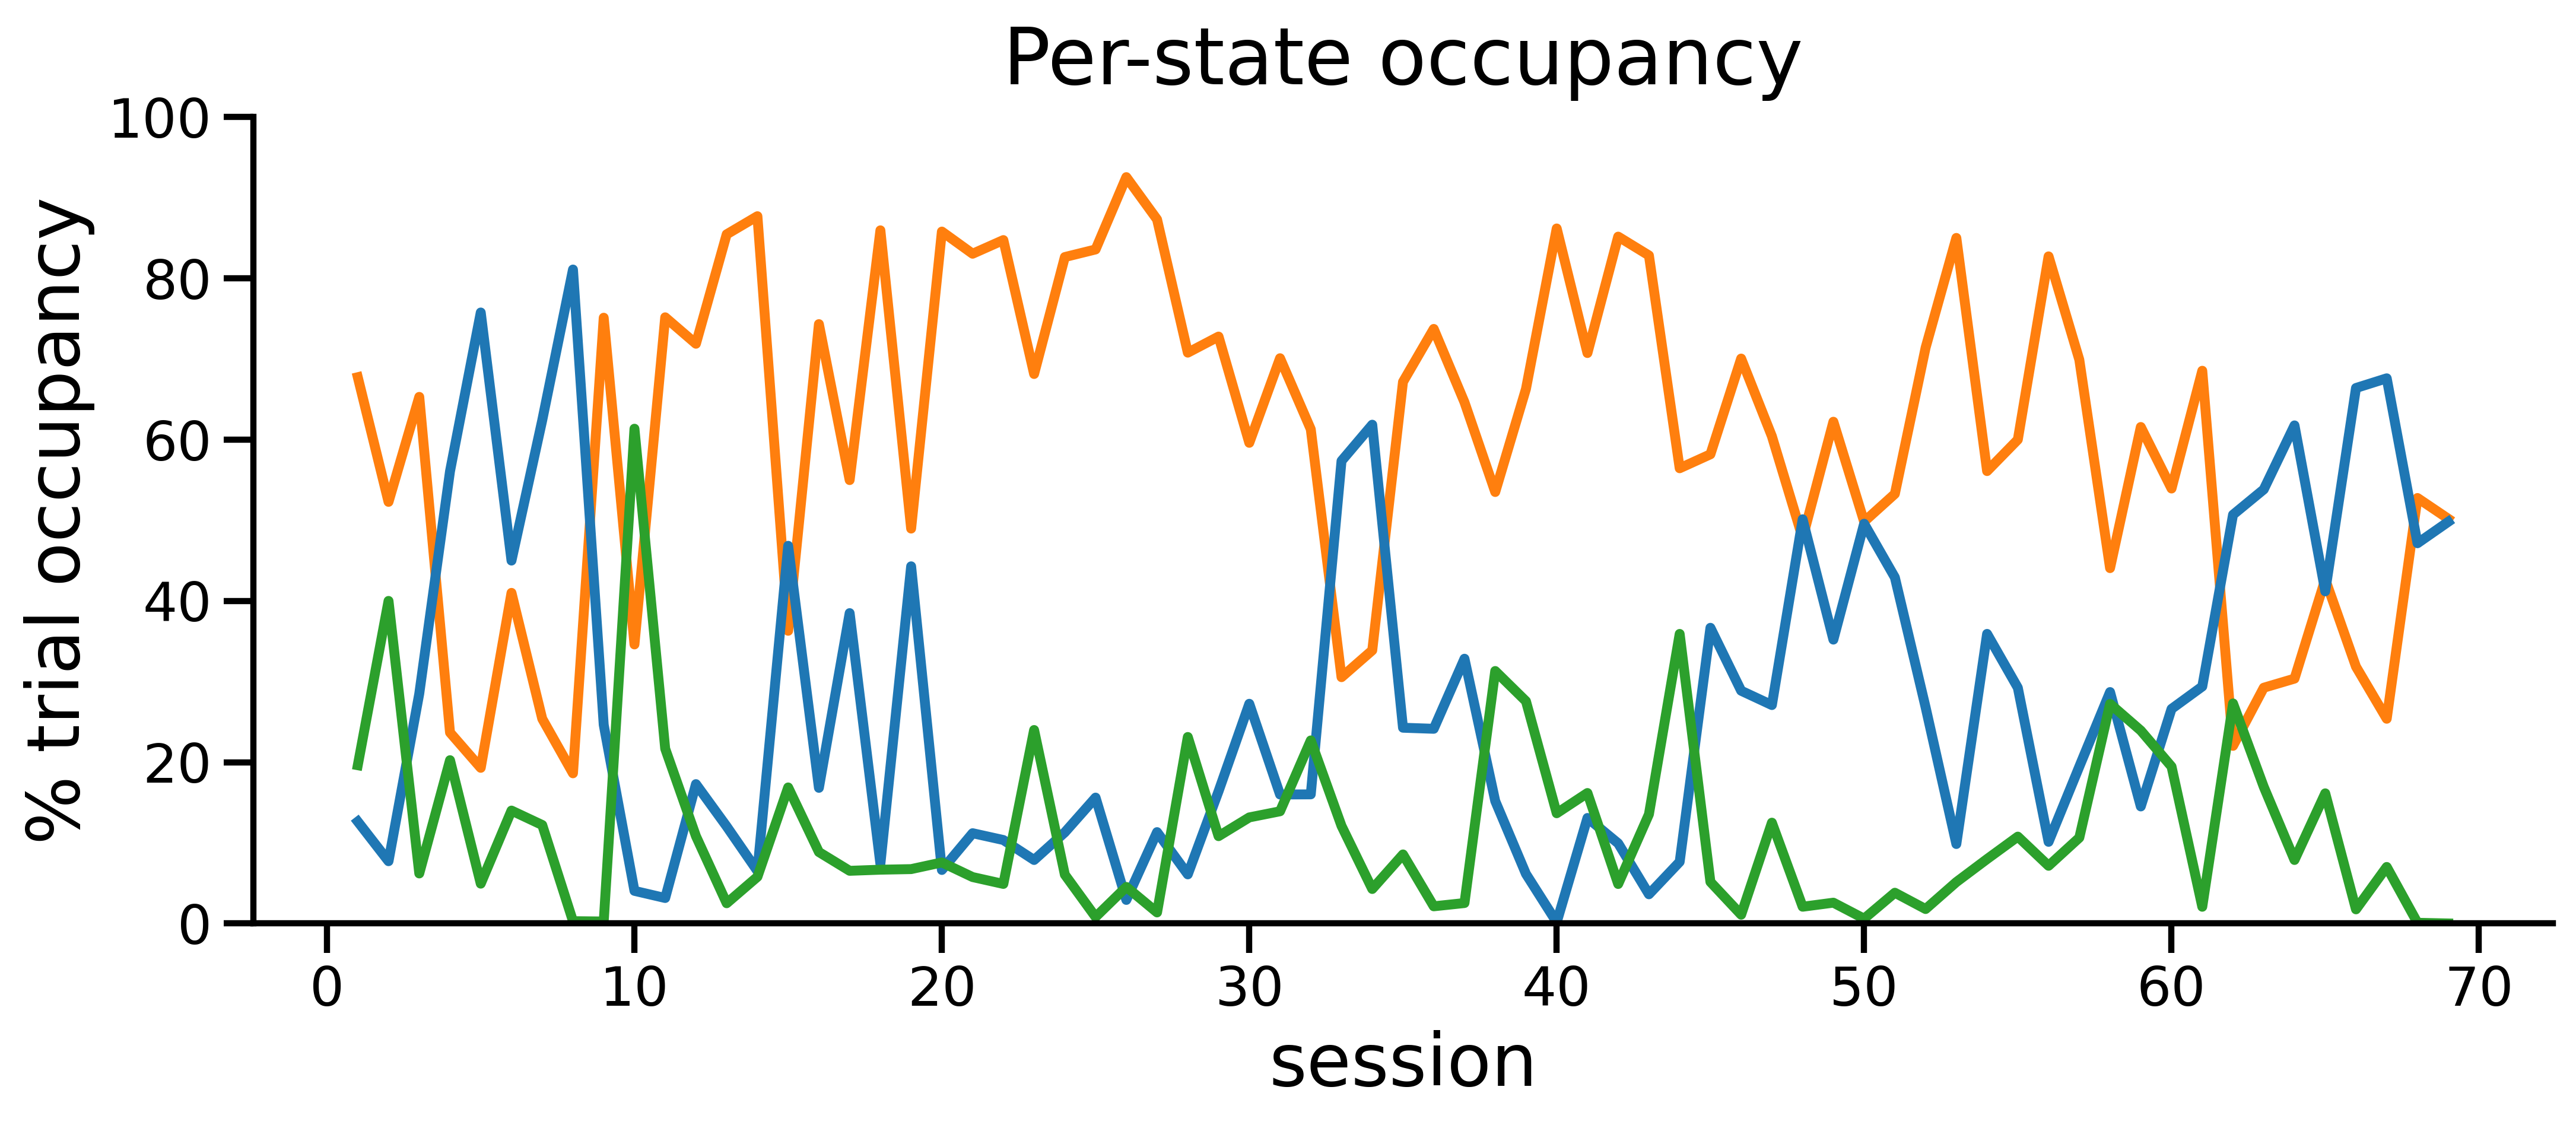

In [11]:
# Plotting task occupancy of each state across sessions
fig, axes = plt.subplots(1, figsize = (12.5,4.5), dpi=400) 
_ = plot_state_occupancy_sessions(gamma, sessInd, axes, colors=colorsStates, linewidth=3, size=24)

# other way of computing occupancies
# p_occ_states_sessions = soft_occupancy_states_sessions(gamma, sessInd)
# for k in range(0,K):
#     axes[0].plot(range(1,len(sessInd)), p_occ_states_sessions[:,k], color=colorsStates[k], linewidth=3, label=f'state {k+1}')

axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Per-state occupancy', size=24, pad=10)
axes.get_legend().remove()
axes.set_xlabel('session', size=22)
plt.savefig(f'../figures/Occupancy_states_{subject}', bbox_inches='tight', dpi=400)

# Figure 2D

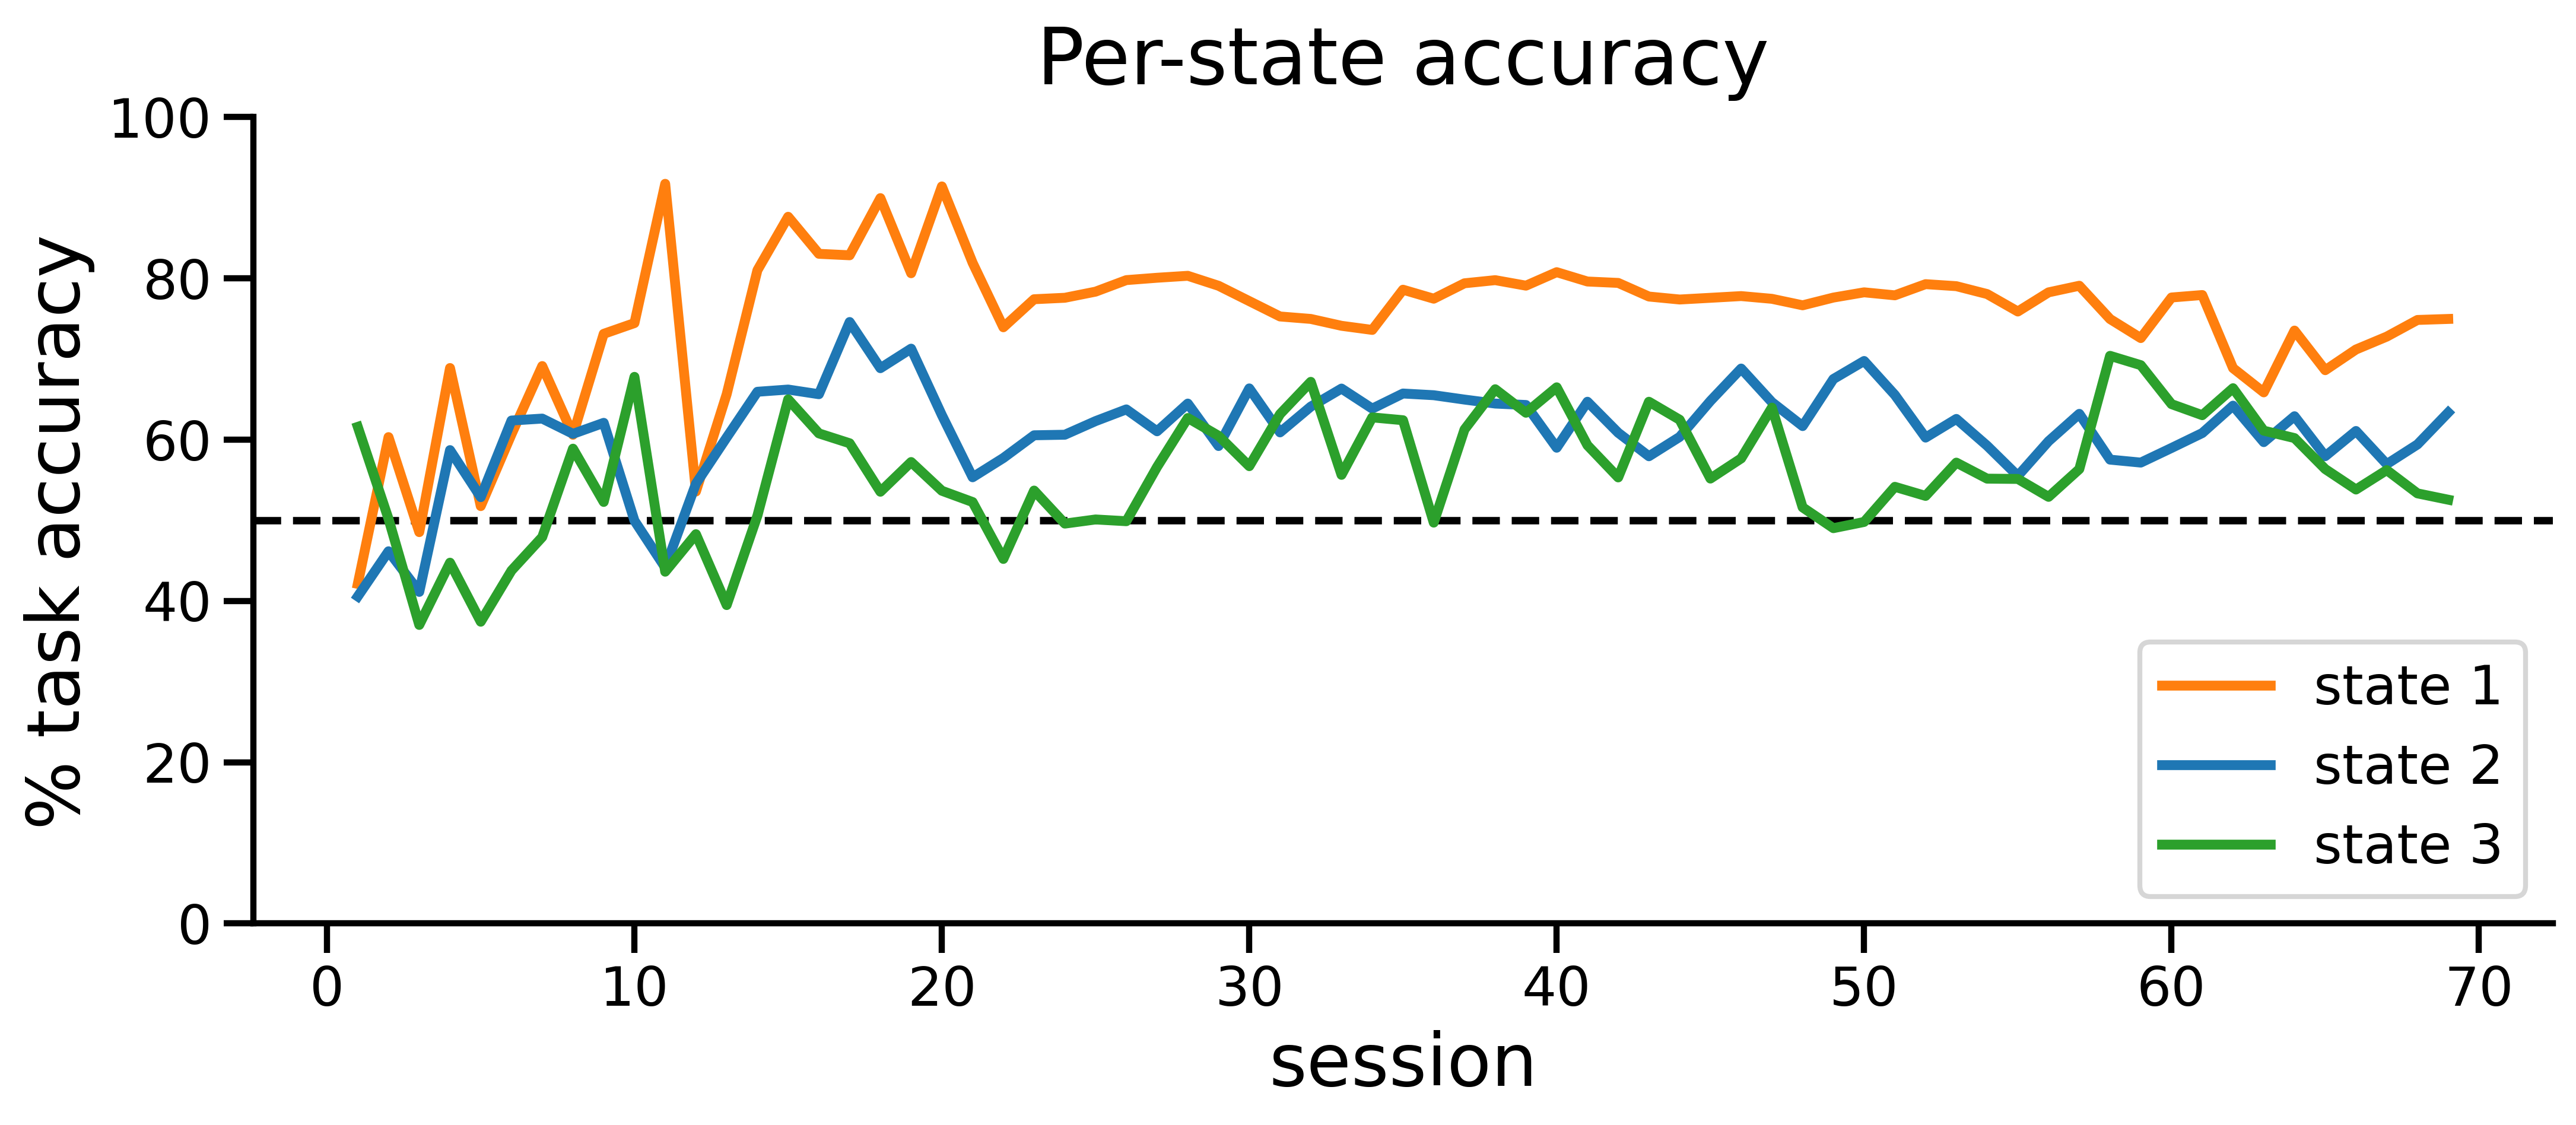

In [12]:
# plotting task accuracy in each state across sessions
p_correct, p_correct_states, p_correct_sessions, p_correct_states_sessions = accuracy_states_sessions(gamma, phi, y, correctSide, sessInd)

# empirical accuracy
empiricalAccuracy = np.zeros((len(sessInd)-1))
correct = correctSide == y
for s in range(0,len(sessInd)-1):
    empiricalAccuracy[s] = np.mean(correct[sessInd[s]:sessInd[s+1]]) * 100

fig, axes = plt.subplots(1, figsize = (12.5,4.5), sharex=True, dpi=400) 
axes.axhline(50,color='black',linestyle='dashed')
for k in range(0,K):
    axes.plot(range(1,len(sessInd)), p_correct_states_sessions[:,k], color=colorsStates[k], linewidth=3, label=f'state {k+1}')
    # axes[1].plot(range(1,len(sessInd)), p_correct_sessions, color='black', linewidth=3)
axes.set_ylim(0,100)
axes.set_ylabel('% task accuracy ', size=22)
axes.set_xlabel('session', size=22)
axes.legend(loc='lower right')

axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Per-state accuracy', size=24, pad=10)
plt.savefig(f'../figures/Accuracy_states_{subject}', bbox_inches='tight', dpi=400)

# Figure 2G

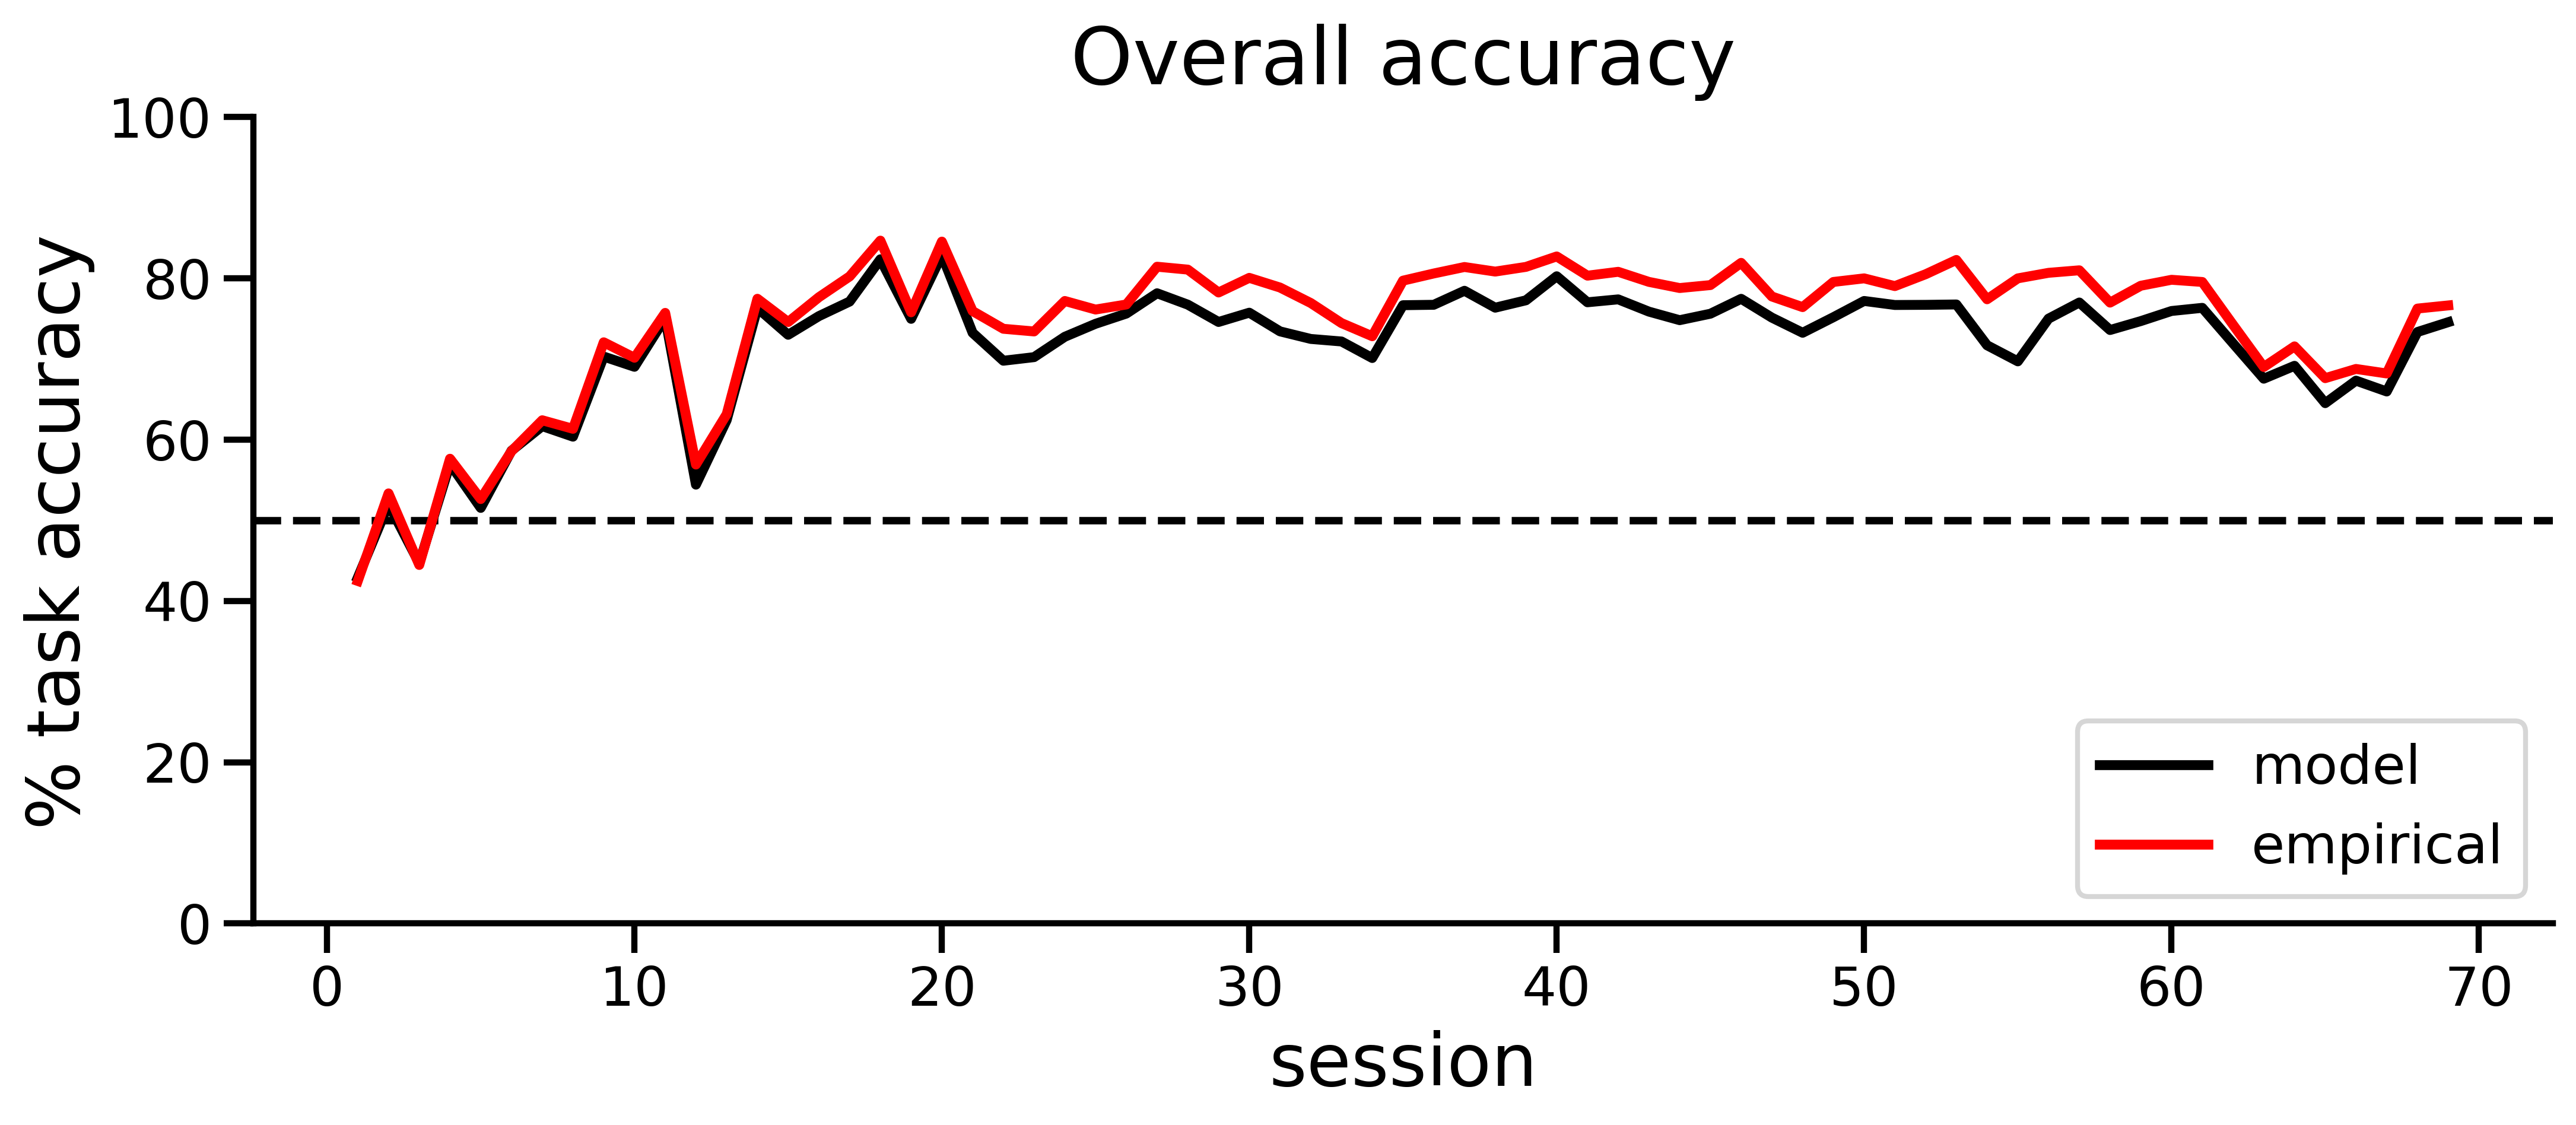

In [16]:
fig, axes = plt.subplots(1, figsize = (12.5,4.5), sharex=True, dpi=400) 
axes.plot(range(1,len(sessInd)), p_correct_sessions, color='black', linewidth=3, label='model')
axes.plot(range(1,len(sessInd)), empiricalAccuracy, color='red', linewidth=3, label='empirical')
# axes[1].plot(range(1,len(sessInd)), p_correct_sessions, color='black', linewidth=3)
axes.set_ylim(0,100)
axes.set_ylabel('% task accuracy ', size=22)
axes.set_xlabel('session', size=22)
axes.axhline(50,color='black',linestyle='dashed', zorder=0)
axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Overall accuracy', size=24, pad=10)
axes.legend(loc='lower right')
plt.savefig(f'../figures/Overall_accuracy_states_{subject}', bbox_inches='tight', dpi=400)

In [14]:
# example sessions for further investigation
sessionsInterest = [0,1,3,6,15,26]
sessionTitle = ['early training','early training','early training','middle training','late training','post-training'] 

# Figure 3A

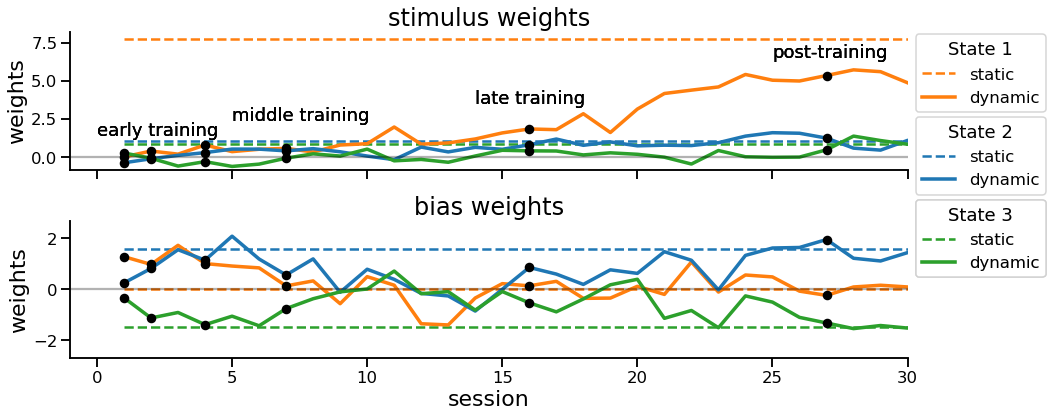

In [15]:
plotSess = len(sessInd)-1 #min(len(sessInd)-1)#,50)
fig, axes = plt.subplots(2, 1,figsize=(13.5,6), sharex=True)#, dpi=400)
fig.tight_layout(pad=2)
yLim=[[-2.7,2.7],[-0.8,8.2],[-2.7,2.7],[-2.7,2.7]]
yText = [[1.4,1.4,1.4,2.4,3.5,6.5]]
for d in range(0, 2):
    axes[d].axhline(0, alpha=0.3, color='black',linestyle='-')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),-allW1[0][sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=2.5, alpha=1, linestyle='--', label='static', zorder=0)
        axes[d].plot(range(1,plotSess+1),-allW[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=3.5, alpha=1, label=f'dynamic', linestyle='-', zorder=1)
        for s in range(0,len(sessionsInterest)):
            axes[d].scatter(sessionsInterest[s]+1, -allW[sessInd[sessionsInterest[s]],k,1-d,1], color='black', zorder=2, s=65)
            if (d==0 and s not in [0,2]):
                axes[d].text(sessionsInterest[s]-1, yText[d][s], sessionTitle[s])
    axes[d].set_ylim(yLim[1-d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights', size=22)
    axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=24)
    axes[d].spines[['right', 'top']].set_visible(False)
    # axes[d].axvline(firstBlockSession+1, color='gray',zorder=0, alpha=1, linewidth=2.5, label='bias blocks introduced')
    axes[0].legend(loc=(1.02,0.2))
    axes[d].set_xlim(-1,30)
lines = axes[0].get_lines()
include = [1,2]
legend1 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(1, 0.7), title = "State 1")
include = [3,4]
legend2 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(1, 0.1), title = "State 2")
include = [5,6]
legend3 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(1, -0.5), title = "State 3")
axes[0].add_artist(legend1)
axes[0].add_artist(legend2)
axes[0].add_artist(legend3)
axes[-1].set_xlabel('session', size=22)
plt.savefig(f'../figures/weights_fig4_{subject}', bbox_inches='tight', dpi=400)

# Figure 3C

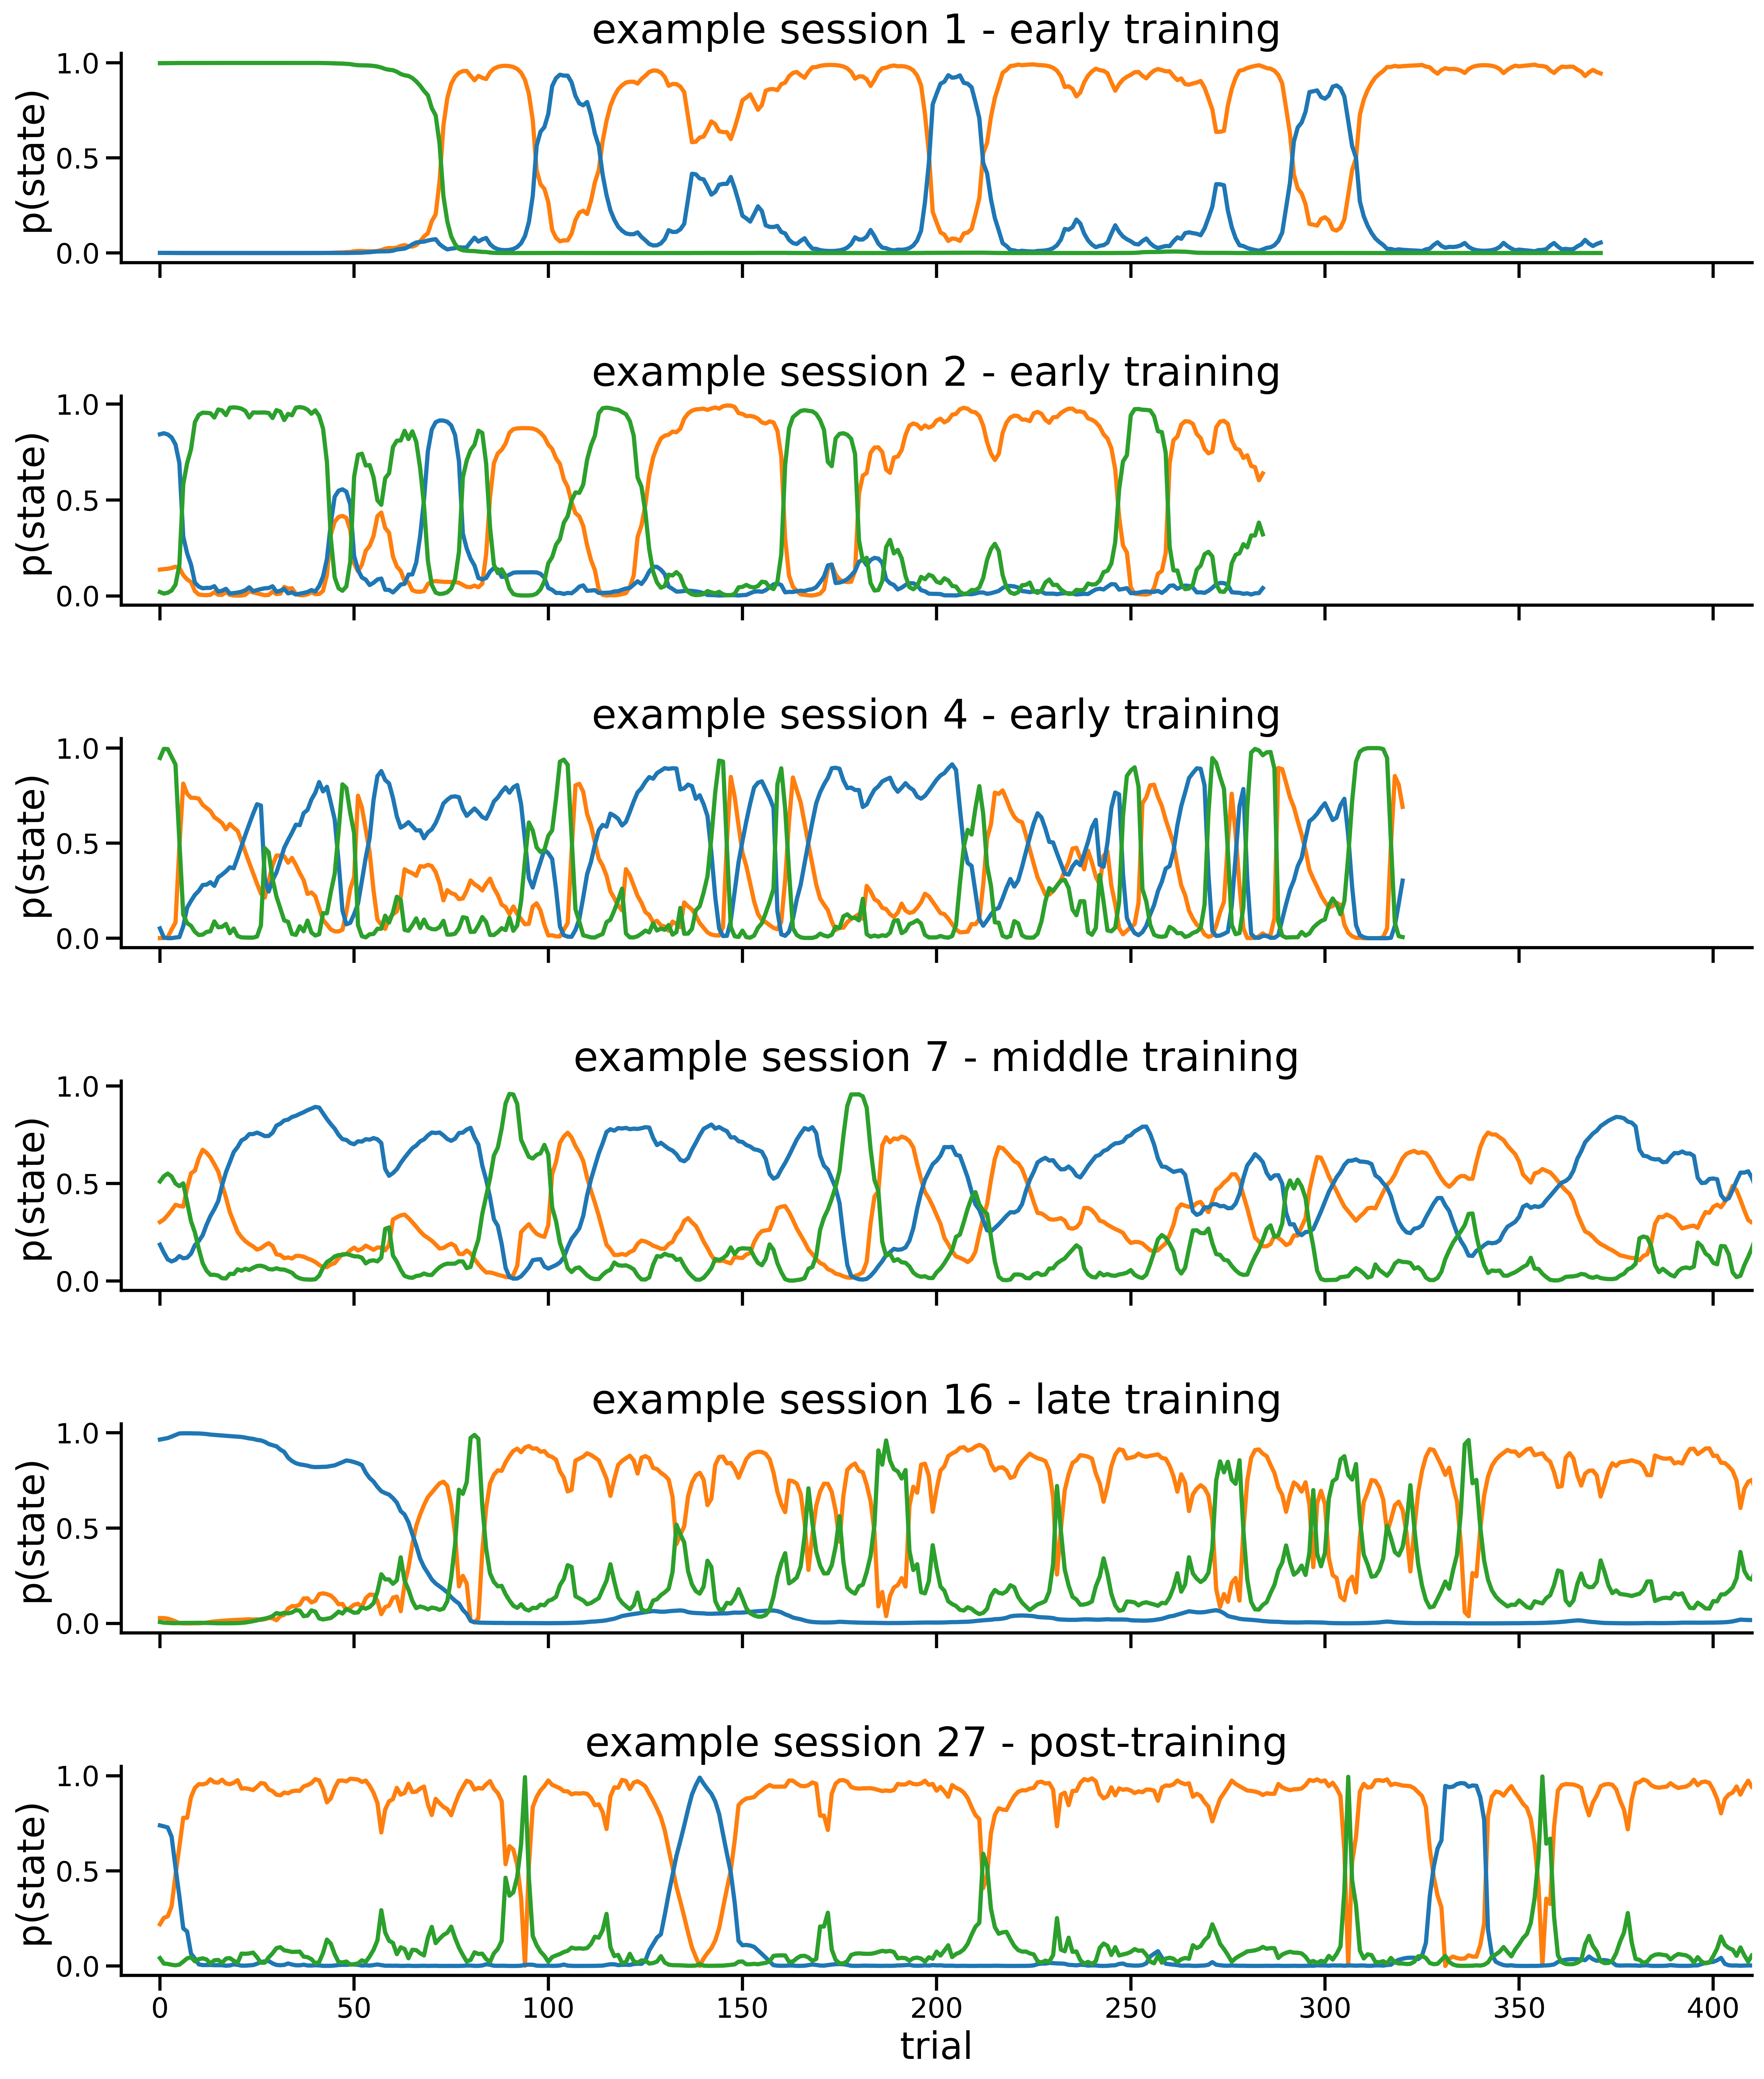

In [16]:
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(16,len(sessionsInterest)*3), dpi=400, sharex=True)
fig.tight_layout(pad=3.5)
plot_posteior_latent(gamma, sessInd, axes, sessions = sessionsInterest, linewidth=2.5)
for s in range(0,len(sessionsInterest)):
    sess = sessionsInterest[s]
    # for t in range(sessInd[sess],sessInd[sess+1]):
    #     if (biasedBlockTrials[t] == 1):
    #         axes[s].axvline(t-sessInd[sess], color='tab:blue', label='right block', zorder=0, alpha=0.3, linewidth=0.85)
    #     elif (biasedBlockTrials[t] == -1):
    #         axes[s].axvline(t-sessInd[sess], color='tab:green', label='left block', zorder=0, alpha=0.3, linewidth=0.85)
    axes[s].set_xlim(-10,410)
    axes[s].set_title(f'example session {sessionsInterest[s]+1} - {sessionTitle[s]}', size=24)
    axes[s].spines[['right', 'top']].set_visible(False)
    axes[s].get_legend().remove()
    axes[s].set_ylabel('p(state)', size=22)
axes[-1].set_xlabel('trial', size=22)
# fig.tight_layout()
plt.savefig(f'../figures/posterior_latent_example-sessions_{subject}', bbox_inches='tight', dpi=400)


# Figure 3B

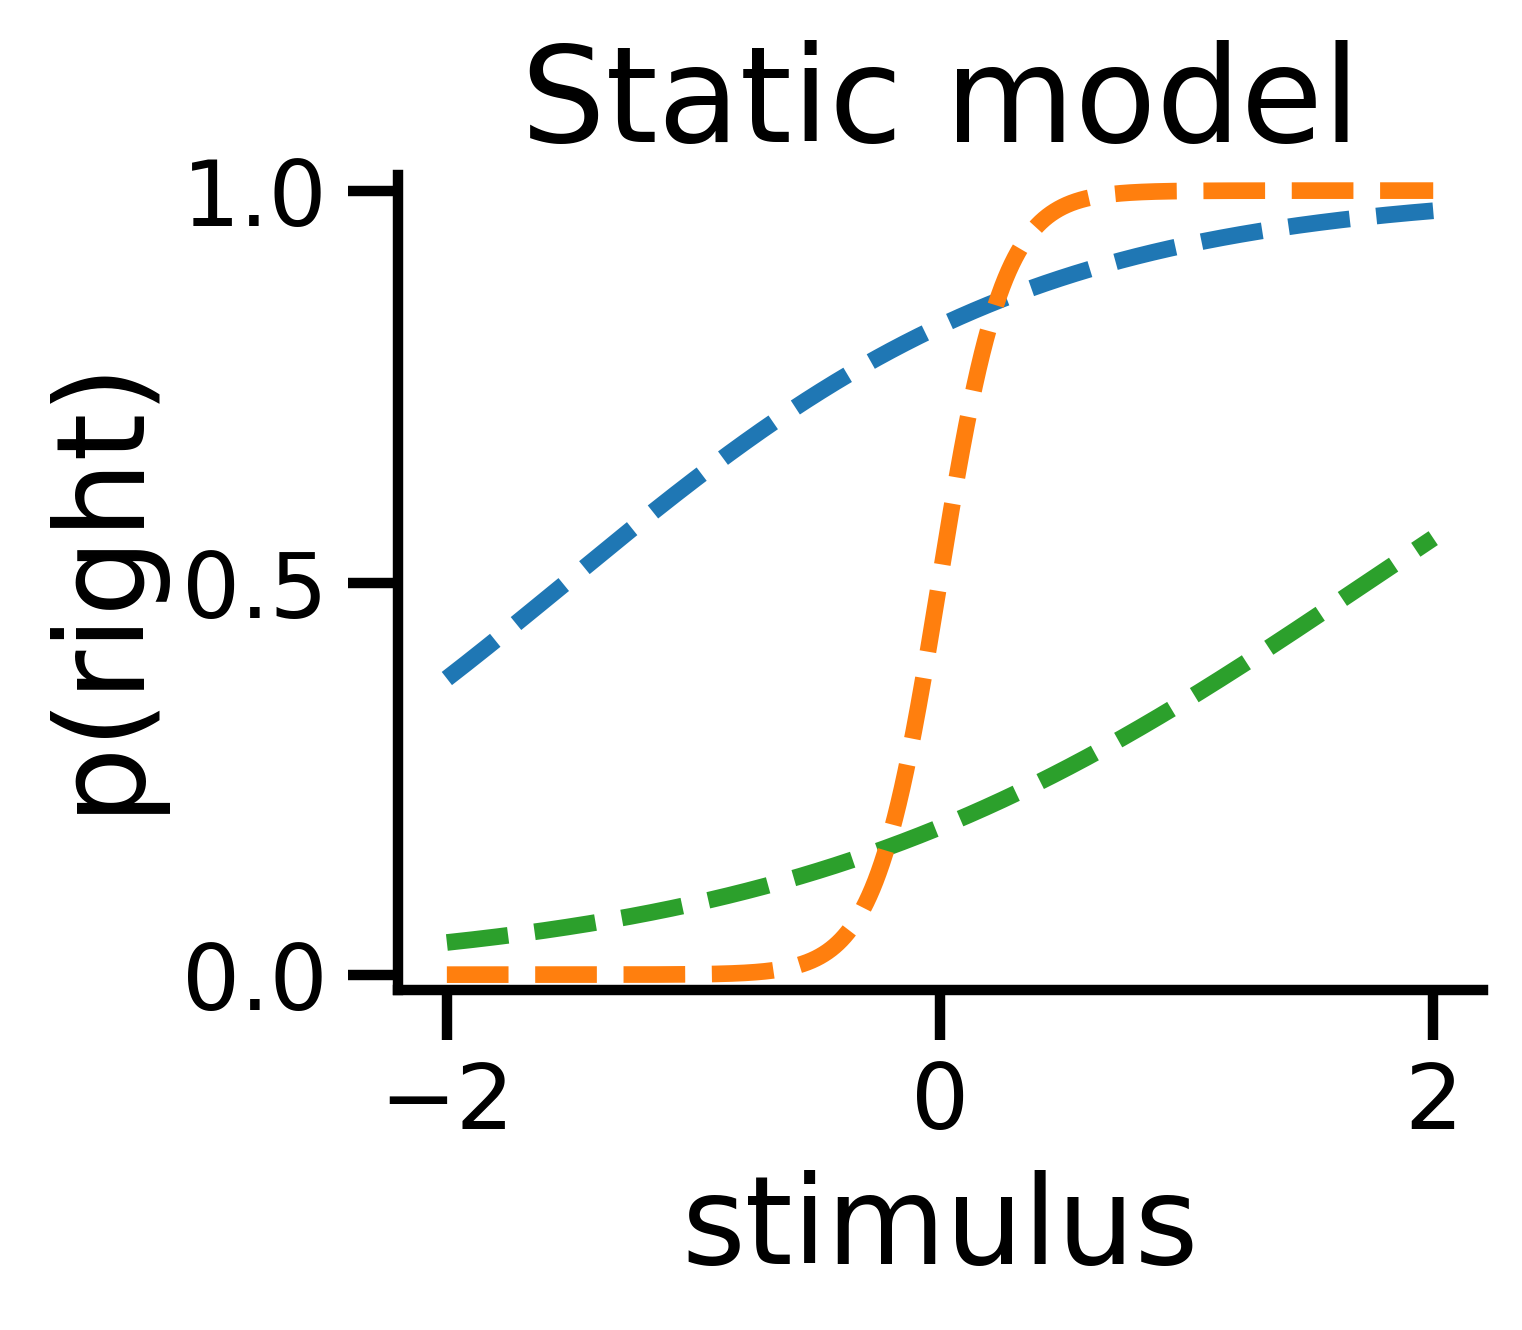

In [17]:
fig, axes = plt.subplots(figsize=(3.5,2.7), dpi=400)
plotting_psychometric(w=-allW1[0], sessInd=sessInd, session=sessionsInterest[s], axes=axes, colorsStates=colorsStates, linestyle='--')
# axes.set_title(f'{sessionTitle[s]}', size=22)#(f'example session - {sessionTitle[s]}', size=22)
axes.set_title(f'Static model', size=24)
axes.spines[['right', 'top']].set_visible(False)
axes.set_ylabel('p(right)', size=22)
axes.set_xlabel('stimulus', size=22)
axes.get_legend().remove()
axes.set_ylim(-0.02,1.02)
# fig.tight_layout()
plt.savefig(f'../figures/psychometric{s}_{subject}', bbox_inches='tight', dpi=400)

# Figure 3D

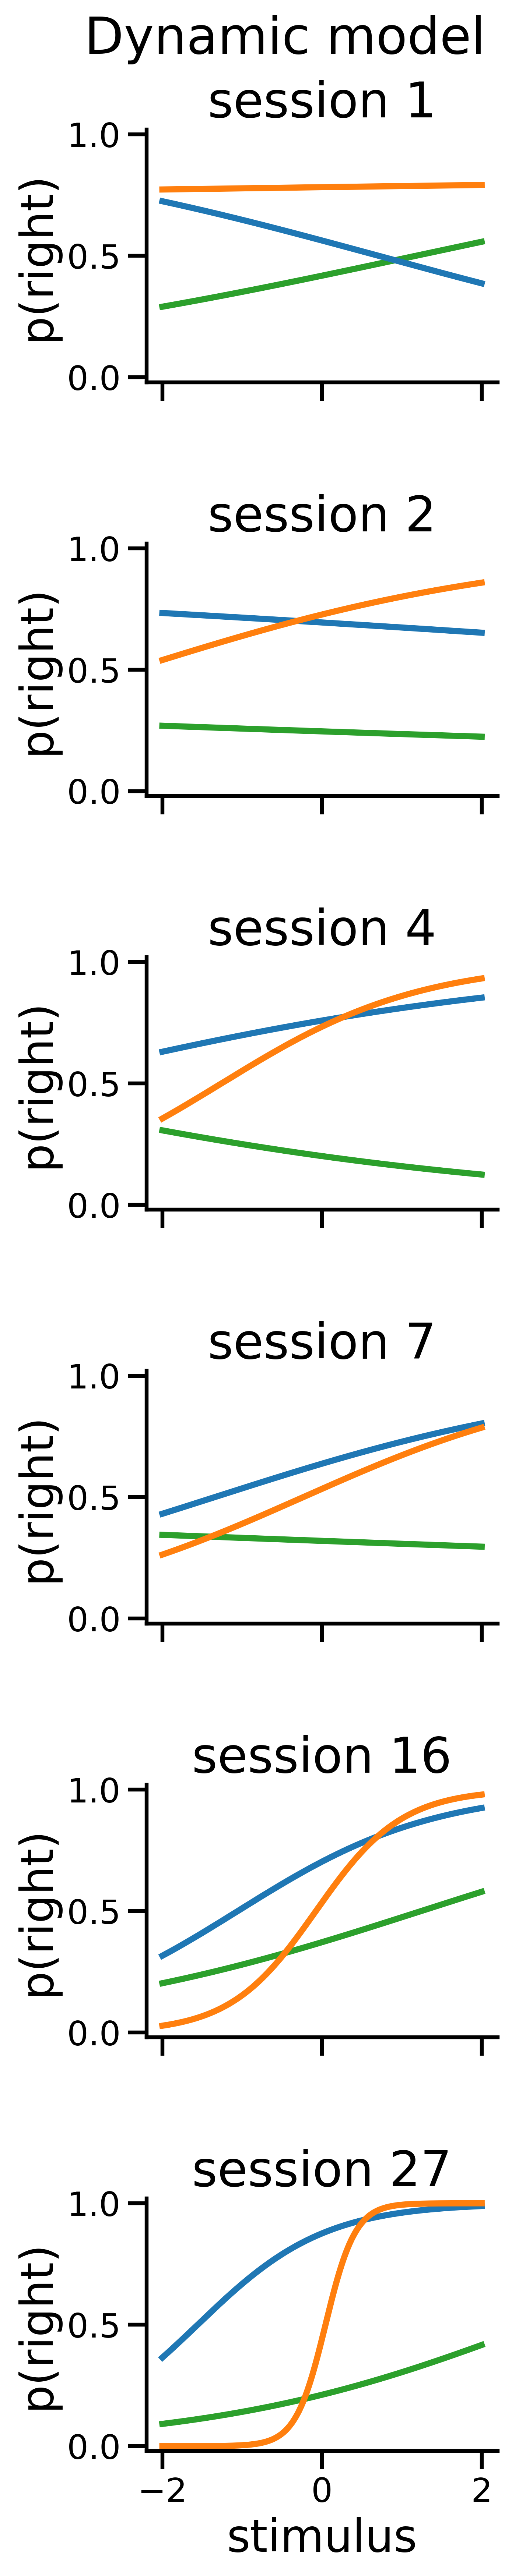

In [18]:
fig, axes = plt.subplots(len(sessionsInterest), 1, figsize=(5,len(sessionsInterest)*3), dpi=400, sharex=True)
fig.tight_layout(pad=3.5)
fig.suptitle('Dynamic model', size=25, y=0.99)
for s in range(0,len(sessionsInterest)):
    plotting_psychometric(w=-allW, sessInd=sessInd, session=sessionsInterest[s], axes=axes[s], colorsStates=colorsStates)
    # axes.set_title(f'{sessionTitle[s]}', size=22)#(f'example session - {sessionTitle[s]}', size=22)
    axes[s].set_title(f'session {sessionsInterest[s]+1}', size=24)
    axes[s].spines[['right', 'top']].set_visible(False)
    axes[s].get_legend().remove()
    axes[s].set_ylabel('p(right)', size=22)
    axes[s].set_xlabel('')  
    axes[s].set_ylim(-0.02,1.02)
    # fig.tight_layout()
axes[-1].set_xlabel('stimulus', size=22)  
plt.savefig(f'../figures/psychometrics_{subject}', bbox_inches='tight', dpi=400)



In [19]:
# number of session to look at (early ones)
sessInterest = 30

testLl_sessions = np.zeros((3, sessInterest, splitFolds))

x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D) # NOT LOOKING AT FULL DATASET
N = x.shape[0]
presentTrain, presentTest = split_data(N, sessInd, folds=splitFolds, blocks=10, random_state=1)
    
data1 = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_1-state_multiple-sigmas_priorDirP={priorDirP}_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')

for fold in range(0, splitFolds):
    data3 = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_3-state_fold-{fold}_multiple-alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
    # data2 = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_2-state_fold-{fold}_multiple-alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
        
    W_3state = data3['W'][bestAlphaInd]
    P_3state = data3['P'][bestAlphaInd]
    pi3 = np.ones((3))/3
    
    # W_2state = data2['W'][bestAlphaInd]
    # P_2state = data2['P'][bestAlphaInd]
    # pi2 = np.ones((3))/3

    dGLM_HMM_3state = dglm_hmm2.dGLM_HMM2(N,3,D,2)
    testLlSessions, _,  _ = dGLM_HMM_3state.evaluate(x, y, sessInd, presentTest[fold], P_3state, pi3, W_3state)
    testLl_sessions[2,:,fold] = testLlSessions[0:sessInterest]

    # dGLM_HMM_2state = dglm_hmm2.dGLM_HMM2(N,2,D,2)
    # testLlSessions = dGLM_HMM_2state.evaluate_per_session(x, y, sessInd, presentTest[fold], P_2state, pi2, W_2state)
    # testLl[1,:,fold] = testLlSessions[0:sessInterest]

    testLl_sessions[0,:,fold] = data1['testLl_sessions'][fold, bestSigmaInd, :sessInterest]


# Figure 3E

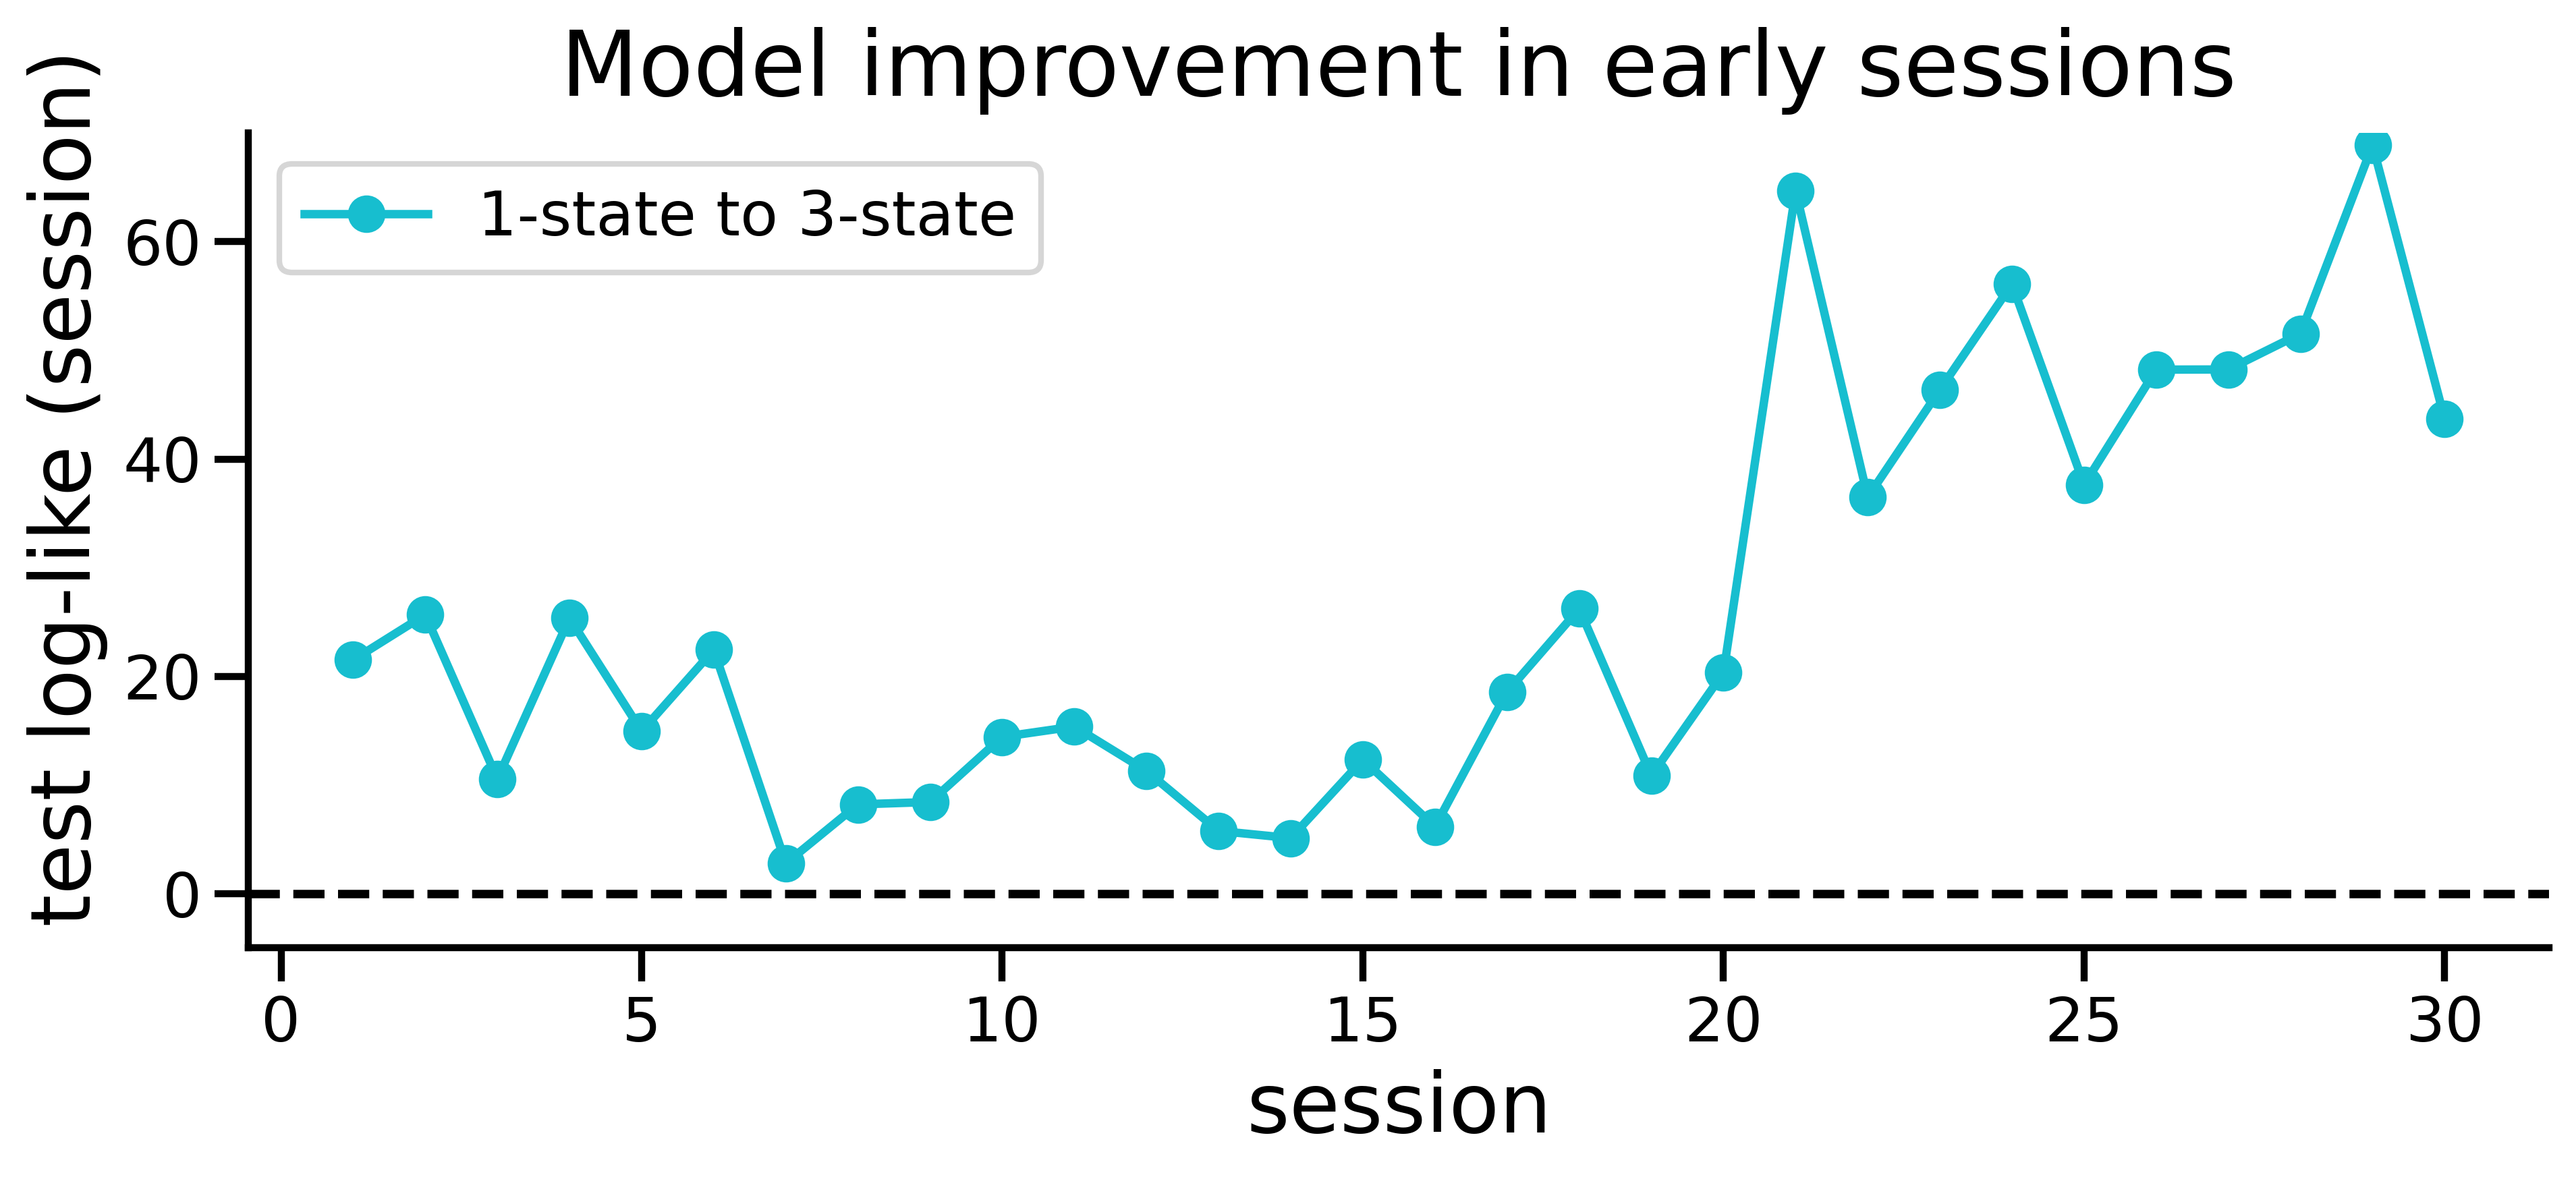

In [20]:
fig, axes = plt.subplots(1, figsize = (11,4), dpi=400)
avgTestLl = np.mean(testLl_sessions, axis=2)
axes.plot(range(1,sessInterest+1), (avgTestLl[2]-avgTestLl[0]) * avg_session_length, '-o', color = colormap[2], label='1-state to 3-state')
axes.set_xlabel('session', size=22)
axes.set_ylabel('    test log-like (session)', size=22)
axes.legend(loc='upper left')
axes.axhline(0, color='black', linestyle='dashed')
axes.set_title('Model improvement in early sessions', size=24, pad=10)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xticks(range(0,31,5),range(0,31,5))
axes.set_ylim(-5,70)
plt.savefig(f'../figures/Test_Log-Like_1vs3states_early_sessions', bbox_inches='tight', dpi=400)

# Figure 3F

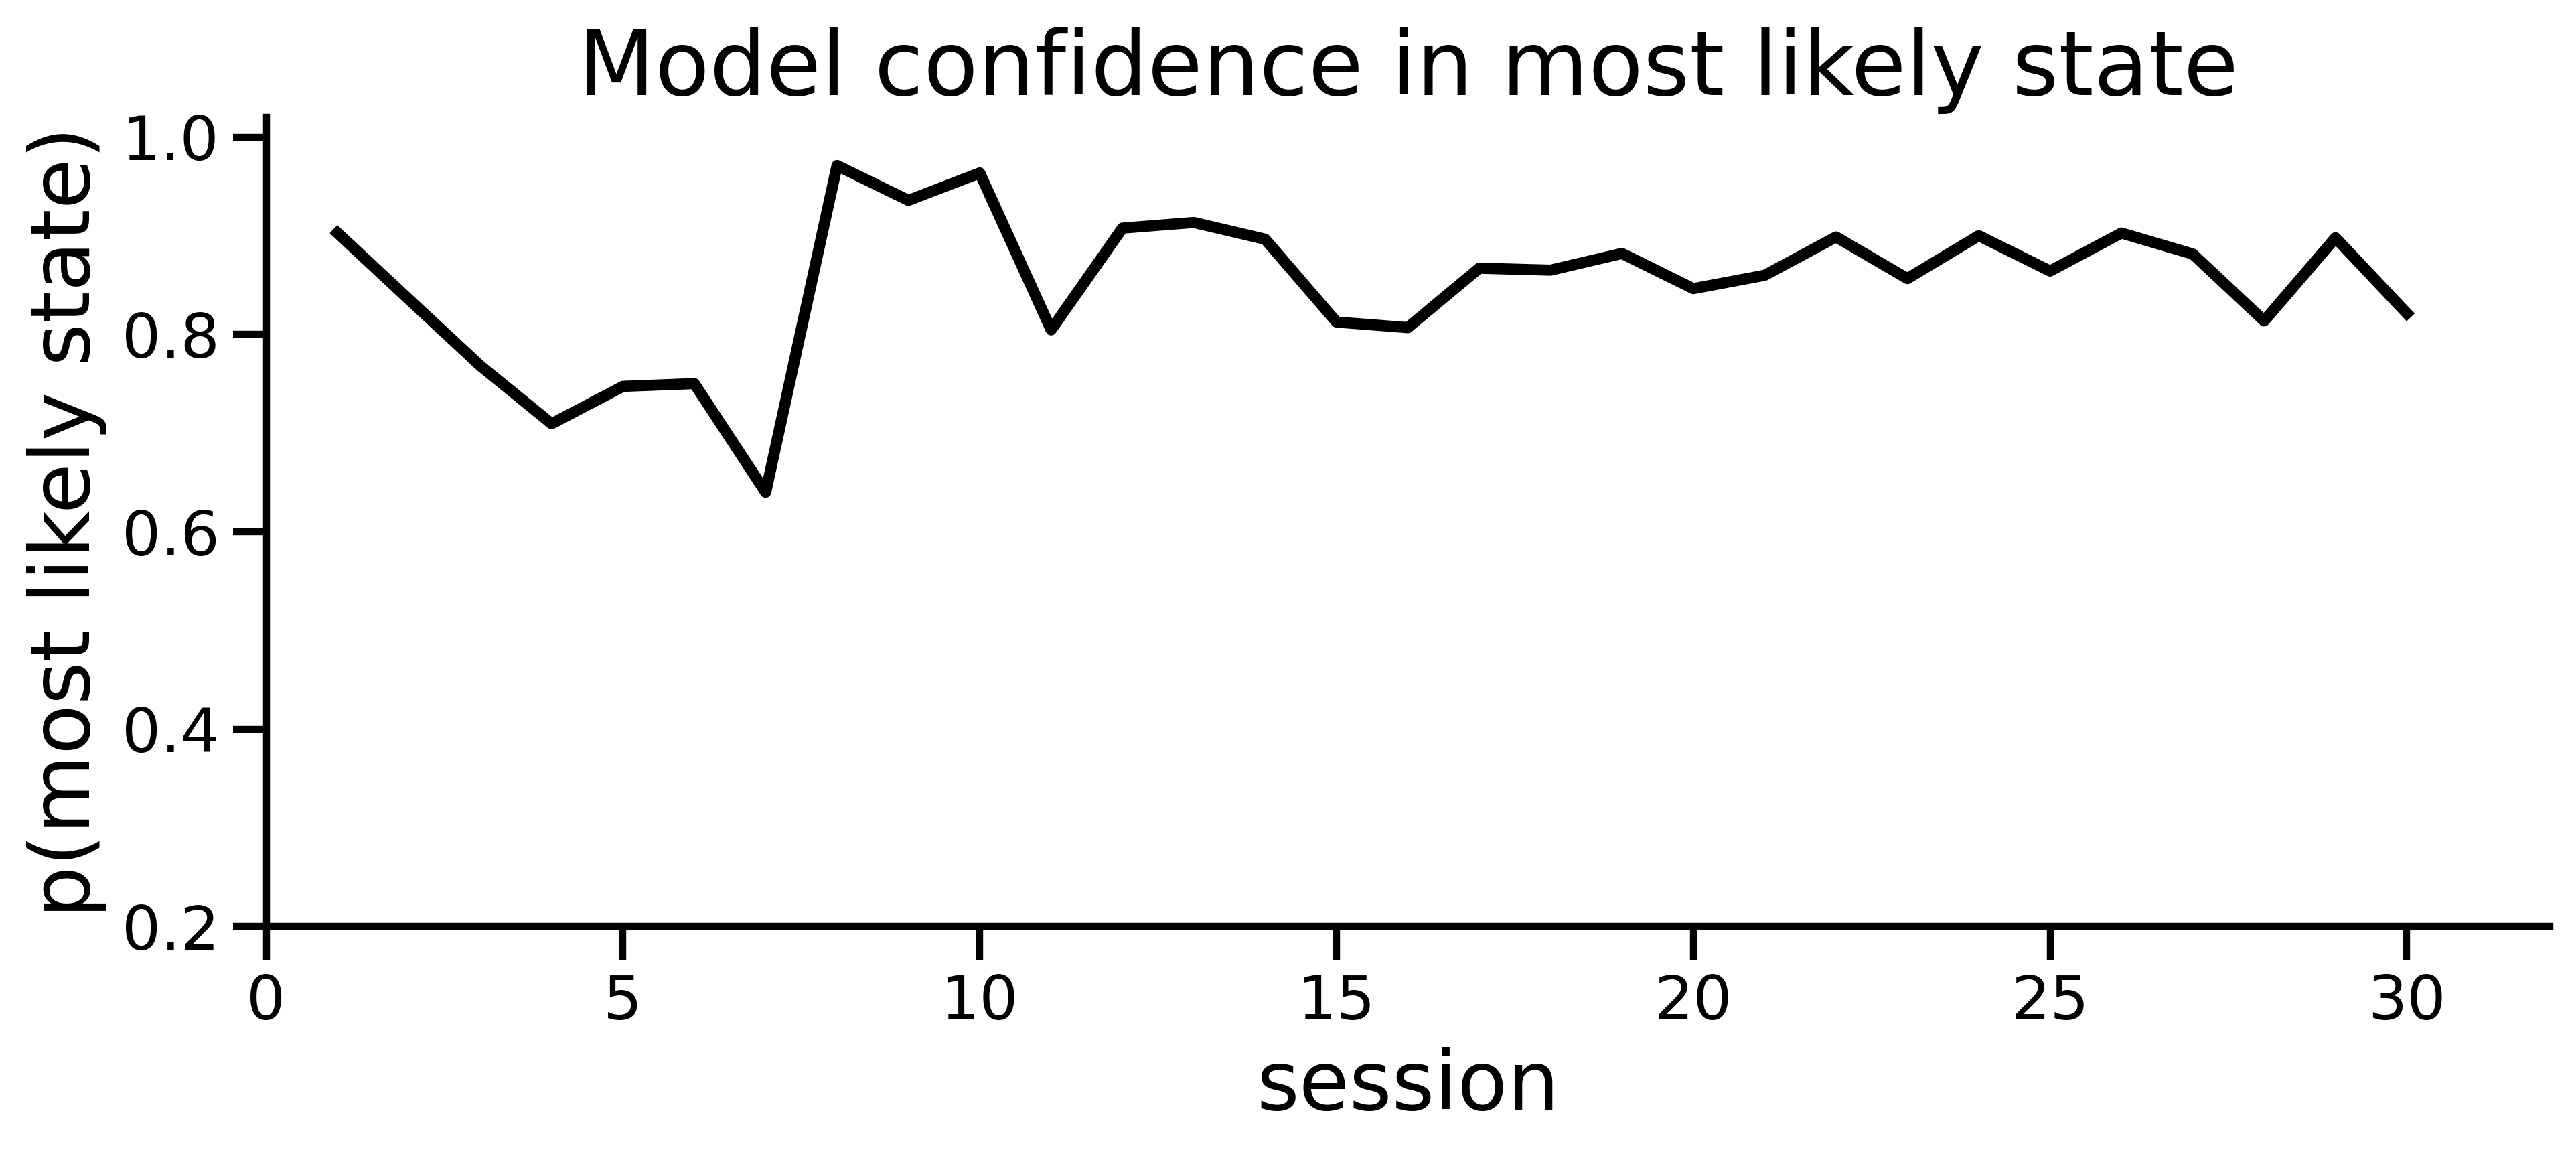

In [21]:
fig, axes = plt.subplots(1, figsize=(11,4), dpi=400)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xlabel('session', size=22)
axes.set_ylabel('p(most likely state)', size=22)
axes.set_ylim(0.2,1.02)
axes.set_xlim(0,sessInterest+2)
axes.set_title('Model confidence in most likely state', size=24)
probMaxSession = distribution_most_likely_state(gamma, sessInd[:sessInterest+1], axes, linewidth=3)
axes.set_xticks(range(0,31,5),range(0,31,5))
plt.savefig(f'../figures/latent_most-likely-state_{subject}', bbox_inches='tight', dpi=400)

# Supplemental Figure 2A

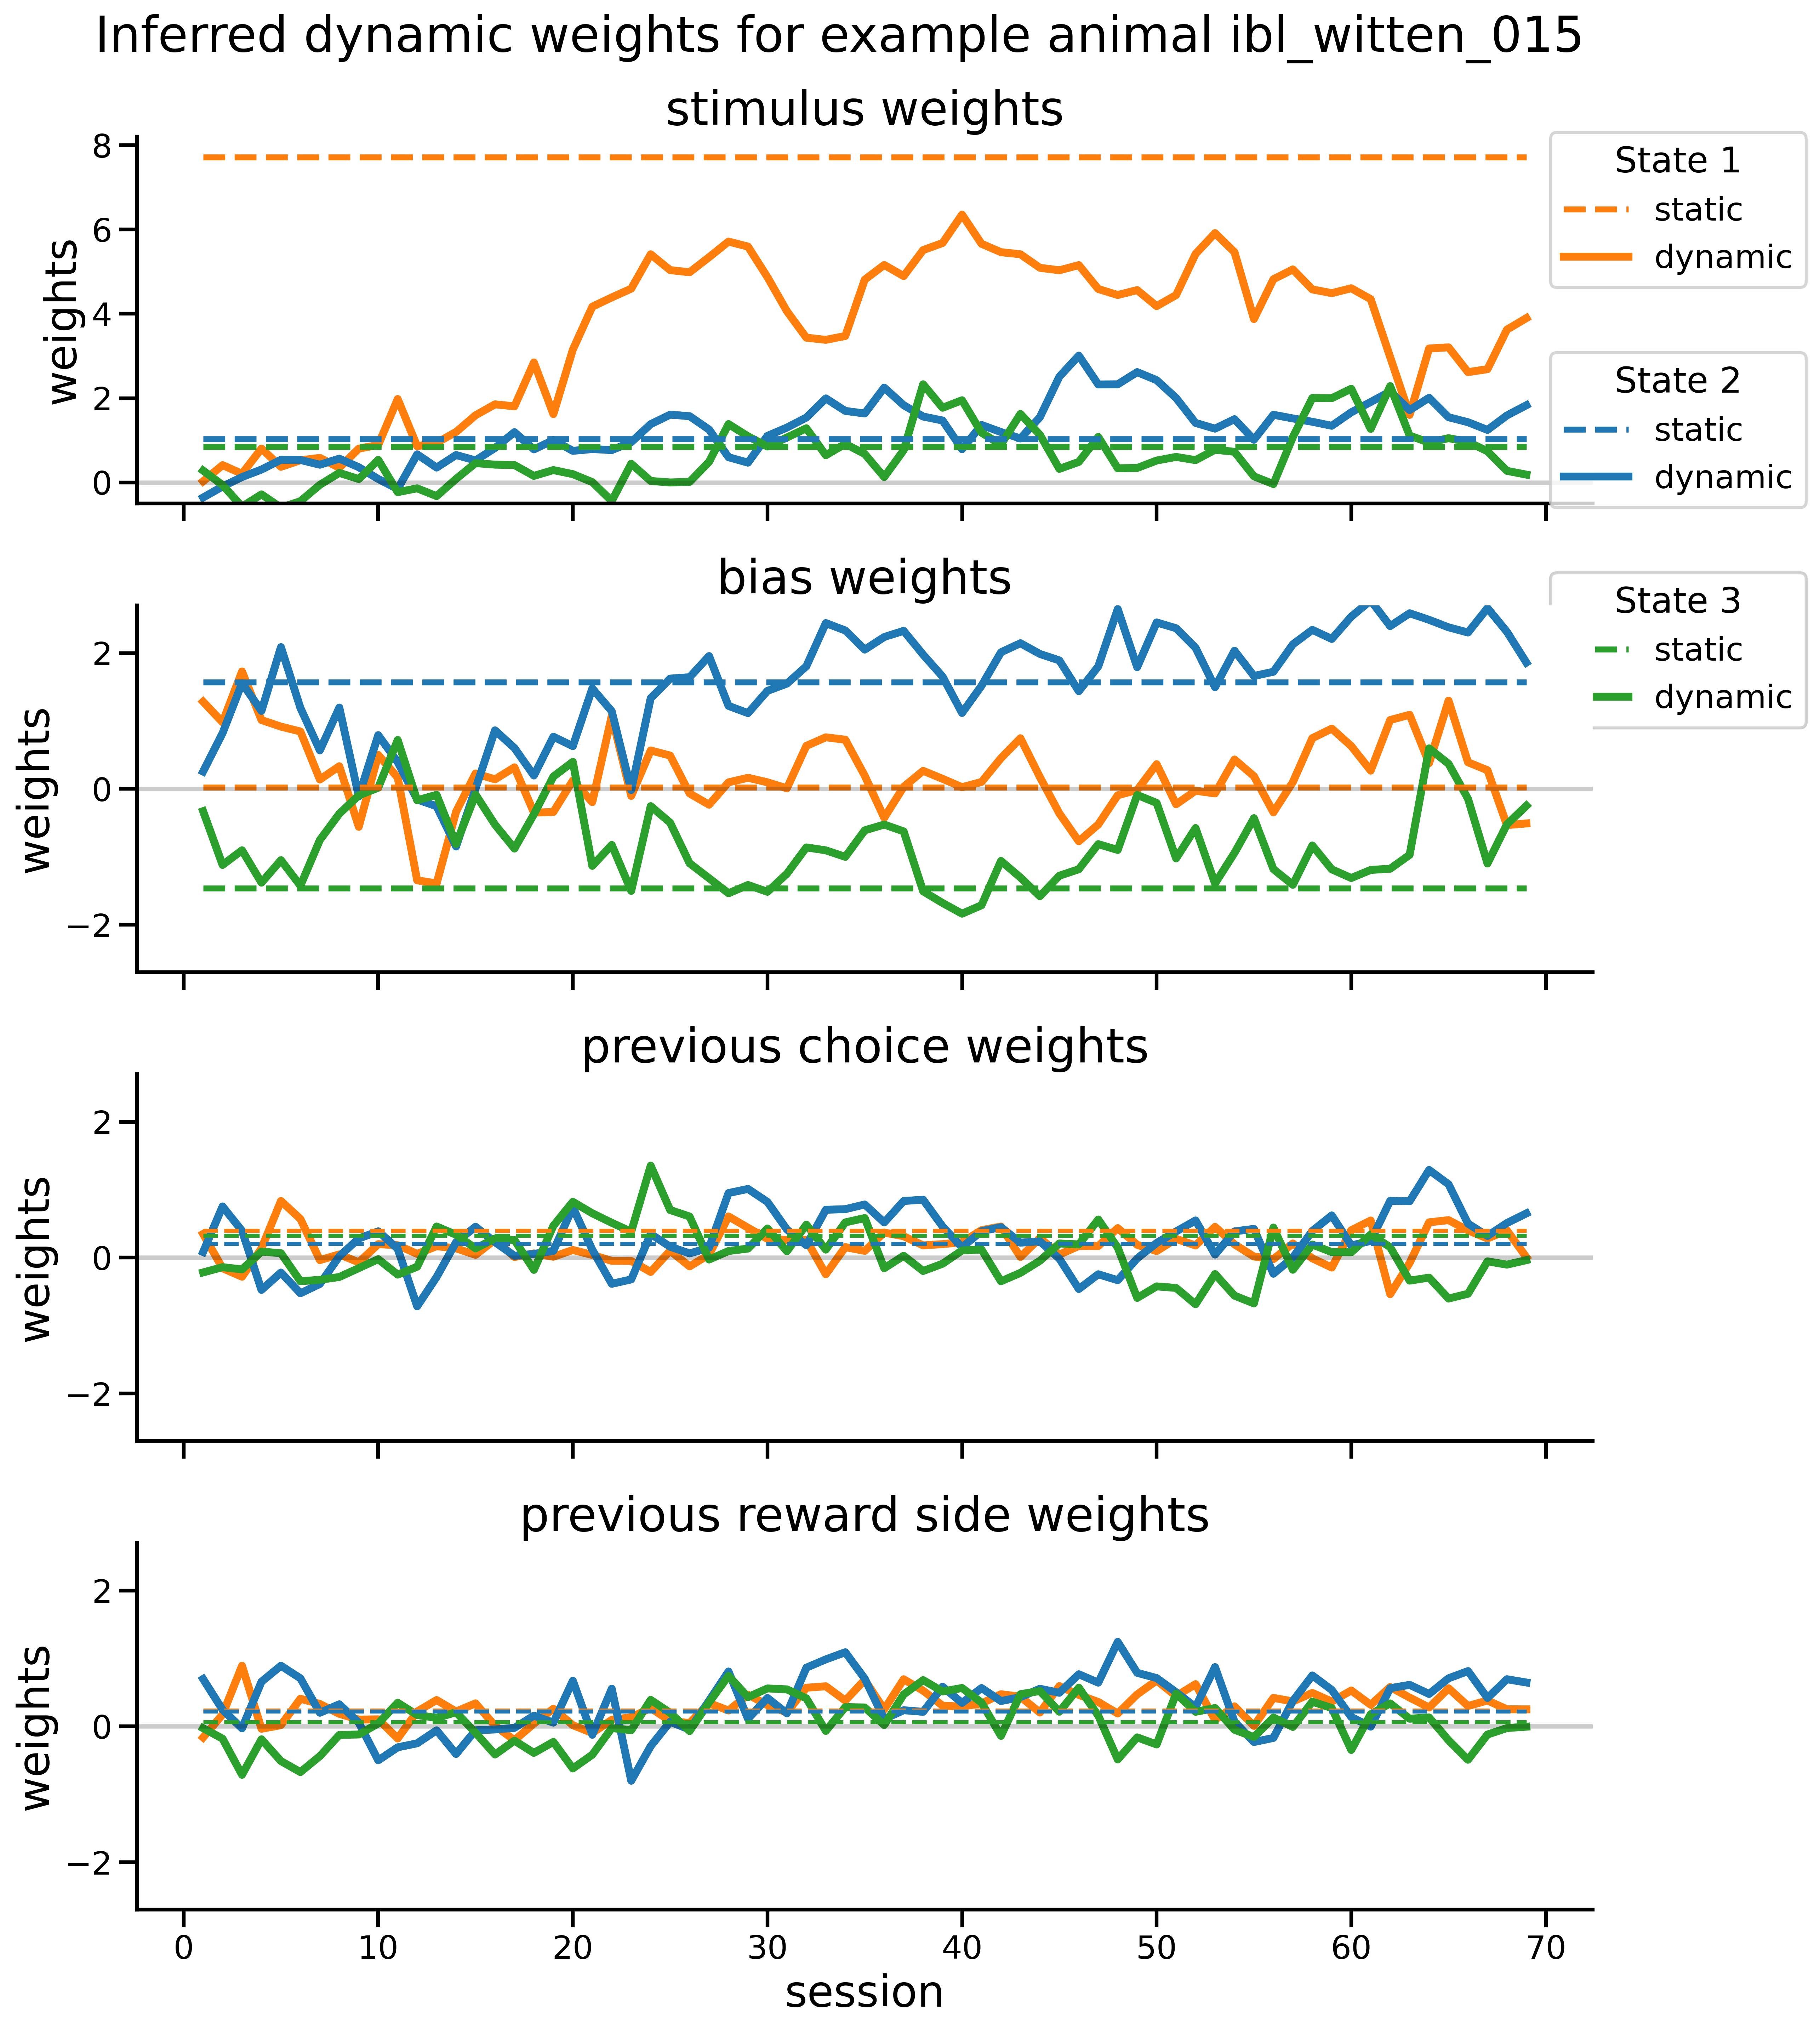

In [30]:
bestSigmaInd = 7
sns.set_context("talk")
myFeatures = [['bias','stimulus', 'previous choice', 'previous reward side'],['bias','contrast left','contrast right', 'previous choice', 'previous reward']]

# computing gamma for bestSigmaInd
dGLM_HMM = dglm_hmm2.dGLM_HMM2(N,K,D,2)
gamma = dGLM_HMM.get_posterior_latent(allP, truepi, allW, x, y, presentAll, sessInd, sortedStateInd=None)
phi = dGLM_HMM.observation_probability(x, allW)
   
plotSess = len(sessInd)-1 
fig, axes = plt.subplots(4, 1,figsize=(12,14), sharex=True, dpi=400)
fig.tight_layout(pad=2)
yLim=[[-2.7,2.7],[-0.5,8.2],[-2.7,2.7],[-2.7,2.7]]
for d in range(0, 2):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),-allW1[0][sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=3, alpha=1, linestyle='--', label='static', zorder=1)
        axes[d].plot(range(1,plotSess+1),-allW[sessInd[:plotSess],k,1-d,1],color=colorsStates[k],linewidth=4, alpha=1, linestyle='-', label='dynamic', zorder=0)
        # for s in sessionsInterest:
        #     axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
    axes[d].set_ylim(yLim[1-d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights', size=22)
    axes[d].set_title(f'{myFeatures[D%2][1-d]} weights', size=24)
    axes[d].spines[['right', 'top']].set_visible(False)

for d in range(2, D):
    axes[d].axhline(0, alpha=0.2, color='black',linestyle='-')
    for k in range(0, K):
        axes[d].plot(range(1,plotSess+1),-allW1[0][sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=2, alpha=1, linestyle='--', label='   =0', zorder=1)
        axes[d].plot(range(1,plotSess+1),-allW[sessInd[:plotSess],k,d,1],color=colorsStates[k],linewidth=4, alpha=1, linestyle='-', label='   =1', zorder=0)
        # for s in sessionsInterest:
        #     axes[d].scatter(s+1, -avgW[bestSigmaInd][sessInd[s],k,d,1], color='black', zorder=2)
    axes[d].set_ylim(yLim[d])
    # axes[d].set_title(f'{myFeatures[D%2][d]}')
    axes[d].set_ylabel(f'weights', size=22)
    axes[d].set_title(f'{myFeatures[D%2][d]} weights', size=24)
    axes[d].spines[['right', 'top']].set_visible(False)
    
lines = axes[0].get_lines()
include = [1,2]
legend1 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, 0.8), title = "State 1")
include = [3,4]
legend2 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, 0.2), title = "State 2")
include = [5,6]
legend3 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.96, -0.4), title = "State 3")
axes[0].add_artist(legend1)
axes[0].add_artist(legend2)
axes[0].add_artist(legend3)
axes[-1].set_xlabel('session', size=22)
fig.suptitle('Inferred dynamic weights for example animal ibl_witten_015', size=25, y=1.02)
plt.savefig(f'../figures/weights_allFeatures_sigma=1_{subject}.png', bbox_inches='tight', dpi=400)